# Euclidean Alignment + Weighted TL

## Load dataset

In [1]:
import sys

In [2]:
sys.path.append('D:\Google_Drive\JupyterNotebookProjects\bci-research\plan_c\csp')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import moabb.datasets
import moabb.paradigms


from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

In [4]:
dframe = pd.DataFrame

In [5]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [6]:
# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    data_path = '../../datasets/BCICIV2a/A{:02d}T.npz'.format(subj)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)

## Preprocessing

### Apply Bandpass Filter

In [7]:
from scipy.signal import firwin, freqs, lfilter

In [8]:
# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [9]:
## PREPROCESSING ##

# Frequency sampling at 250 Hz
fs = 250

# Applying bandpass filter 8-30 Hz to all subjects raw EEG
b = fir_bandpass(51, low=8, high=30, fs=fs)

# Key to store result
EEG_filtered = 'EEG_filtered'

for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    mod_data[subj][EEG_filtered] = apply_bandpass(temp_raw_EEG, b)

### Fetch Left and Right Class

In [10]:
mod_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [11]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 'EEG_filtered'])

In [12]:
## Only fetch left and right class
mod_data = fetch_left_right_EEG(mod_data, ori_data=ori_data)
    
# Checking current size of EEG left and right data
print('\t\tLeft \t\t Right')

for subj in mod_data.keys():
    
    temp = mod_data[subj]
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['EEG_left'].shape, temp['EEG_right'].shape)) 

Processing for  1
Processing for  2
Processing for  3
Processing for  4
Processing for  5
Processing for  6
Processing for  7
Processing for  8
Processing for  9
		Left 		 Right
subject01:	(72, 22, 750)	(72, 22, 750)
subject02:	(72, 22, 750)	(72, 22, 750)
subject03:	(72, 22, 750)	(72, 22, 750)
subject04:	(72, 22, 750)	(72, 22, 750)
subject05:	(72, 22, 750)	(72, 22, 750)
subject06:	(72, 22, 750)	(72, 22, 750)
subject07:	(72, 22, 750)	(72, 22, 750)
subject08:	(72, 22, 750)	(72, 22, 750)
subject09:	(72, 22, 750)	(72, 22, 750)


In [13]:
# NEWLY ADDED FUNCTION PRCESS samples x chann of EEG FILTERED -> trials x samples x channel
for subj in mod_data.keys():
    process_s_data(mod_data[subj])
    print(mod_data[subj]['all_trials'].shape)

(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)
(144, 22, 750)


In [14]:
mod_data[1]['y']

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 0., 0., 1., 0.])

## Apply Data Alignment on raw EEG

In [15]:
# Import necessary library
from scipy.linalg import sqrtm, inv 

def apply_EA(data, key_list):
    '''
    Apply Euclidean aligment on array-like objects for 1 subject
    
    PARAMETER:
    data:
    dictionary data of one subject.
    dictionary containing either:
    - left and right EEG data of each subject 
    - combined all_trials
    
    key_list:
    keys inside dict in which data that is about to be aligned are stored
    
    OUTPUT:
    dictionary data with aligned version of key_list
    '''
    
    # So that this function can handles separated or combined left and right trials
    # If they are separated
    if len(key_list) > 1:
        # Concatenate left and right class
        print('processing separated left and right')
        left_key = [key for key in key_list if 'left' in key]
        right_key = [key for key in key_list if 'right' in key]

        left_trial = data[left_key[0]]
        right_trial = data[right_key[0]]

        # Concate both left and right trial
        all_trials = np.concatenate([left_trial, right_trial], axis=0)
    # If they are not separated
    else:
        print('processing combined left and right')
        all_trials = data[key_list[0]]
    
    # Calculate reference matrix
    RefEA = 0

    # Iterate over all trials, compute reference EA
    for trial in all_trials:
        cov = np.cov(trial, rowvar=True)
        RefEA += cov

    # Average over all trials
    RefEA = RefEA/all_trials.shape[0]

    # Add to data
    data['RefEA'] = RefEA 
    
    # Compute R^(-0.5)
    R_inv = sqrtm(inv(RefEA))
    
    # Again here, they way we stored the key is distinguised
    if len(key_list) > 1:
        # Perform alignment on each trial
        X_EA_left = []
        X_EA_right = []

        for left, right in zip(left_trial, right_trial):
            X_EA_left.append(R_inv@left)
            X_EA_right.append(R_inv@right)

        # Store as left_EA and right_EA
        print('Adding EA_left and EA_right key ')
        data['EEG_left_EA'] = np.array(X_EA_left)
        data['EEG_right_EA'] = np.array(X_EA_right)
    
    # If they are not separated
    else:
        print('storing back into dict')
        all_trials = data[key_list[0]]
            
        # Perform EA on each trial
        all_trials_EA = []
        
        for t in all_trials:
            all_trials_EA.append(R_inv@t)
        
        # Store them back in data dict
        data['all_trials_EA'] = np.array(all_trials_EA)

In [16]:
# Iterate over all subjects to apply EA to all trials
# Define keys to be processed
process_key = ['all_trials']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
processing combined left and right
storing back into dict

Processing subject  2
processing combined left and right
storing back into dict

Processing subject  3
processing combined left and right
storing back into dict

Processing subject  4
processing combined left and right
storing back into dict

Processing subject  5
processing combined left and right
storing back into dict

Processing subject  6
processing combined left and right
storing back into dict

Processing subject  7
processing combined left and right
storing back into dict

Processing subject  8
processing combined left and right
storing back into dict

Processing subject  9
processing combined left and right
storing back into dict



In [22]:
# Iterate over all subjects to compute the aligned EEG trials
# Define keys to be processed
process_key = ['EEG_left', 'EEG_right']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    apply_EA(mod_data[subj], process_key)
    print('')

Processing subject  1
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  2
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  3
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  4
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  5
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  6
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  7
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  8
processing separated left and right
Adding EA_left and EA_right key 

Processing subject  9
processing separated left and right
Adding EA_left and EA_right key 



In [23]:
dframe(mod_data[3]['RefEA']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,25.650872,23.801770,25.398874,25.969270,25.502569,24.422906,19.415399,22.233508,24.068148,24.978227,...,21.427256,20.954147,22.368313,22.995651,22.929910,22.174650,20.525057,21.372880,21.020488,19.286099
1,23.801770,27.150986,26.371489,25.228500,23.802053,22.853112,22.410394,26.478632,26.046298,25.150637,...,20.105167,24.662392,24.560350,23.922925,23.004374,21.853748,22.627830,22.651384,21.776484,20.669979
2,25.398874,26.371489,27.433290,26.801438,25.802470,24.355214,21.774037,25.934938,26.985381,26.826847,...,21.532928,24.657343,25.605606,25.475202,24.800236,23.546719,23.584205,24.065762,23.291589,21.773354
3,25.969270,25.228500,26.801438,27.659533,26.845201,25.791479,20.371825,24.371657,26.244570,27.521350,...,22.458781,23.524072,24.970348,25.987195,25.584203,24.493158,23.287790,24.273317,23.791855,21.863690
4,25.502569,23.802053,25.802470,26.845201,27.173689,26.567991,19.680616,23.040357,25.509831,27.048137,...,23.987477,22.726972,24.718662,26.050557,26.392743,25.843799,23.431771,24.796053,24.798946,22.553711


In [17]:
left_alg = mod_data[1]['all_trials_EA']

In [18]:
left_alg.shape

(144, 22, 750)

In [19]:
summ = 0
for tr in left_alg:
    summ += np.cov(tr, rowvar=True)
    
I = summ/left_alg.shape[0]
I = pd.DataFrame(np.round(I))

In [20]:
I

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0
1,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,-0.0,0.0,1.0,0.0,-0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0
4,-0.0,-0.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0
5,-0.0,0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
6,0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,1.0,-0.0,...,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0
9,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,1.0,...,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Sanity check
for subj in mod_data.keys():
    summ = 0
    
#     left_alg = mod_data[subj]['EEG_left_EA']
#     right_alg = mod_data[subj]['EEG_right_EA']
    left_alg = mod_data[subj]['all_trials_EA']

    for tr in left_alg:
        summ += np.cov(tr, rowvar=True)
    
    I = summ/left_alg.shape[0]
    I = pd.DataFrame(np.round(I))
    
    # Sum up all matrix elements should equal to number of eeg channels, i.e. 22
    assert (I.sum().sum() == 22)
    print('Subject {} OK!'.format(subj))

Subject 1 OK!
Subject 2 OK!
Subject 3 OK!
Subject 4 OK!
Subject 5 OK!
Subject 6 OK!
Subject 7 OK!
Subject 8 OK!
Subject 9 OK!


## Visualize raw data with and without EA

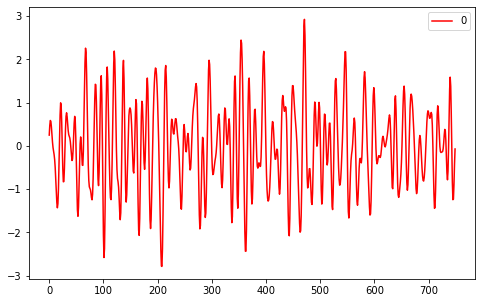

In [29]:
# let's try for one subject
fig, ax = plt.subplots(1, 1,  figsize=(8, 5))
n_alg = pd.DataFrame(mod_data[1]['EEG_left'][10][5])
alg = pd.DataFrame(mod_data[1]['EEG_left_EA'][10][5])

# n_alg.plot(ax=ax, color='k')
alg.plot(ax=ax, color='red')
plt.show()

In [50]:
def visualize_raw_and_aligned(data_dict, no_subj=1, no_trial=0, fs=250):
    '''
    Will plot the visualization of dictionary, left and right hand class
    
    Parameter:
    data_dict = data containing data of each subject
    '''
    if 'EEG_left_EA' in mod_data[no_subj].keys():
        left = data_dict[no_subj]['EEG_left'][no_trial]
        right = data_dict[no_subj]['EEG_right'][no_trial]
        left_alg = data_dict[no_subj]['EEG_left_EA'][no_trial]
        right_alg = data_dict[no_subj]['EEG_right_EA'][no_trial]
    else:
        y = data_dict[no_subj]['y']
        left = data_dict[no_subj]['all_trials'][y==0][no_trial]
        right = data_dict[no_subj]['all_trials'][y==1][no_trial]
        left_alg = data_dict[no_subj]['all_trials_EA'][y==0][no_trial]
        right_alg = data_dict[no_subj]['all_trials_EA'][y==1][no_trial]
    
    # Time
    time = np.arange(left.shape[1])/fs
    
    # Number of electrodes
    n_el = left.shape[0]
    
    # Plot each raw EEG and aligned raw EEG
    fig, axes = plt.subplots(n_el, 2, figsize=(10, 15), sharex=True)
    
    # Title to each column
    axes[0, 0].set_title('Left')
    axes[0, 1].set_title('Right')

    # Plot each eeg raw and aligned 
    for i, ax in enumerate(axes):
        ax[0].plot(time, left[i], color='k', label='el ' + str(i))
        ax[0].plot(time, left_alg[i], color='r', label='el ' + str(i))
        ax[0].legend(loc=1)
        
        ax[1].plot(time, right[i], color='k', label='el ' + str(i))
        ax[1].plot(time, right_alg[i], color='r', label='el ' + str(i))
        ax[1].legend(loc=1)
    plt.savefig('nonEA_vs_EA.png')
    plt.show()

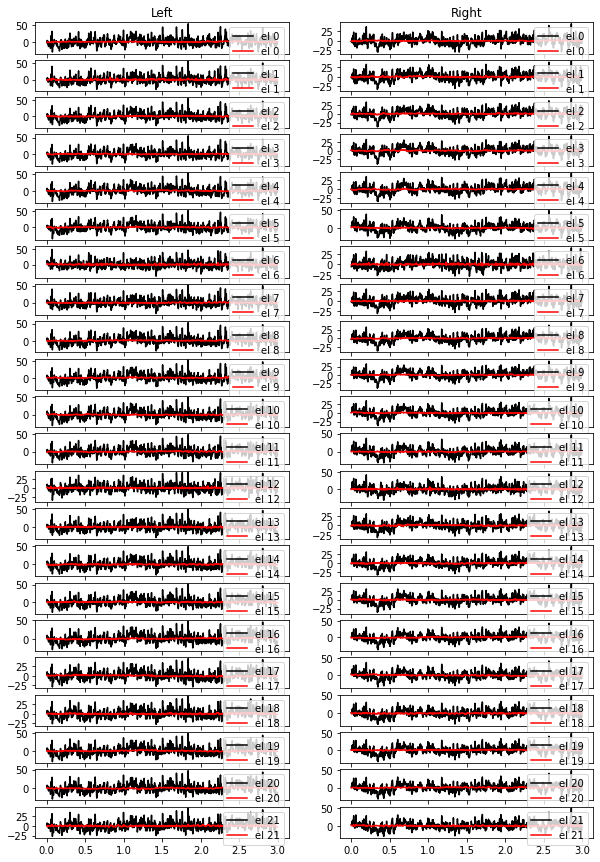

In [51]:
visualize_raw_and_aligned(mod_data, no_subj=2, no_trial=0, fs=250)

## Run CSP for both raw EEG and raw EEG aligned
Should test EEG raw be aligned?

In [32]:
## Split to train and test data
np.random.seed(42)
for subj in mod_data.keys():
    print('Processing split for', subj)
    
    mod_data[subj]['left_train'], mod_data[subj]['left_test'] = split_EEG_one_class(mod_data[subj]['EEG_left'], 0.8)
    mod_data[subj]['right_train'], mod_data[subj]['right_test'] = split_EEG_one_class(mod_data[subj]['EEG_right'], 0.8)     
 
    mod_data[subj]['left_train_EA'], mod_data[subj]['left_test_EA'] = split_EEG_one_class(mod_data[subj]['EEG_left_EA'], 0.8)
    mod_data[subj]['right_train_EA'], mod_data[subj]['right_test_EA'] = split_EEG_one_class(mod_data[subj]['EEG_right_EA'], 0.8)   

Processing split for 1
Processing split for 2
Processing split for 3
Processing split for 4
Processing split for 5
Processing split for 6
Processing split for 7
Processing split for 8
Processing split for 9


In [33]:
# Checking size of EEG left and right data training and test data
print("==================== Not Aligned ======================")
print('\t\tLeft \t\t Right')
print('TRAINING')
for subj in mod_data.keys():
    
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_train'].shape, temp['right_train'].shape))

print('TEST')
for subj in mod_data.keys():

    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_test'].shape, temp['right_test'].shape))

print("\n==================== Aligned ======================")
print('TRAINING')
for subj in mod_data.keys():
    
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_train_EA'].shape, temp['right_train_EA'].shape))

print('TEST')
for subj in mod_data.keys():

    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(subj, temp['left_test_EA'].shape, temp['right_test_EA'].shape))    


==================== Not Aligned ======================
		Left 		 Right
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22, 750)
subject05:	(58, 22, 750)	(58, 22, 750)
subject06:	(58, 22, 750)	(58, 22, 750)
subject07:	(58, 22, 750)	(58, 22, 750)
subject08:	(58, 22, 750)	(58, 22, 750)
subject09:	(58, 22, 750)	(58, 22, 750)
TEST
subject01:	(14, 22, 750)	(14, 22, 750)
subject02:	(14, 22, 750)	(14, 22, 750)
subject03:	(14, 22, 750)	(14, 22, 750)
subject04:	(14, 22, 750)	(14, 22, 750)
subject05:	(14, 22, 750)	(14, 22, 750)
subject06:	(14, 22, 750)	(14, 22, 750)
subject07:	(14, 22, 750)	(14, 22, 750)
subject08:	(14, 22, 750)	(14, 22, 750)
subject09:	(14, 22, 750)	(14, 22, 750)

==================== Aligned ======================
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22,

## CSP

### For Not Aligned

In [34]:
csp = CSP()

print("====================== Not Aligned Data =====================")
for subj in mod_data.keys():

    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP']['cov_left'] = csp.compute_cov(mod_data[subj]['left_train'])
    mod_data[subj]['CSP']['cov_right'] = csp.compute_cov(mod_data[subj]['right_train'])
    mod_data[subj]['CSP']['cov_comp']  = mod_data[subj]['CSP']['cov_left'] + mod_data[subj]['CSP']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP']['whitening']
    temp_cov = mod_data[subj]['CSP']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP']['S_left'] = {}
    mod_data[subj]['CSP']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    Cl = mod_data[subj]['CSP']['cov_left']
    Cr = mod_data[subj]['CSP']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP']['S_left']
    temp_Sr = mod_data[subj]['CSP']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP']['whitening']['P']
    
    mod_data[subj]['CSP']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

====================== Not Aligned Data =====================
Computing cov for  1
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  1
 
Computing cov for  2
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  2
 
Computing cov for  3
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  3
 
Computing cov for  4
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite 

### Aligned Data

In [35]:
csp = CSP()

print("====================== Aligned Data =====================")
for subj in mod_data.keys():

    print('Computing cov for ', subj)
    print('---------------------------')
    
    mod_data[subj]['CSP_EA'] = {}
    
    # Covariance
    print('Computing covariance of each class and composite covariance')
    mod_data[subj]['CSP_EA']['cov_left'] = csp.compute_cov(mod_data[subj]['EEG_left_EA'])
    mod_data[subj]['CSP_EA']['cov_right'] = csp.compute_cov(mod_data[subj]['EEG_right_EA'])
    mod_data[subj]['CSP_EA']['cov_comp']  = mod_data[subj]['CSP_EA']['cov_left'] + mod_data[subj]['CSP_EA']['cov_right']
    
    # Whitening matrix
    print('Computing eigenval, eigenvec, and whitening matrix of composite covariance ')
    mod_data[subj]['CSP_EA']['whitening'] = {}
    
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening = mod_data[subj]['CSP_EA']['whitening']
    temp_cov = mod_data[subj]['CSP_EA']['cov_comp']
    
    temp_whitening['eigval'], temp_whitening['eigvec'] = csp.decompose_cov(temp_cov)

    # White matrix
    temp_whitening['P'] = csp.white_matrix(temp_whitening['eigval'], temp_whitening['eigvec'])
    
    # Common eigenvec from Sl and Sr
    print('Generating common eigenvector from each class')
    mod_data[subj]['CSP_EA']['S_left'] = {}
    mod_data[subj]['CSP_EA']['S_right'] = {}  
    
    # Where to access data
    temp_P = mod_data[subj]['CSP_EA']['whitening']['P']
    Cl = mod_data[subj]['CSP_EA']['cov_left']
    Cr = mod_data[subj]['CSP_EA']['cov_right']
    
    # Where to store result
    temp_Sl = mod_data[subj]['CSP_EA']['S_left']
    temp_Sr = mod_data[subj]['CSP_EA']['S_right']

    # LEFT
    Sl = csp.compute_S(Cl, temp_P)
    temp_Sl['eigvec'], temp_Sl['eigval'] = csp.decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = csp.compute_S(Cr, temp_P)
    temp_Sr['eigvec'], temp_Sr['eigval'] = csp.decompose_S(Sr, 'ascending')   
    
    # Spatial filter
    print('Spatial filter for ',subj)
    temp_eigvec = mod_data[subj]['CSP_EA']['S_left']['eigvec']
    temp_P = mod_data[subj]['CSP_EA']['whitening']['P']
    
    mod_data[subj]['CSP_EA']['W'] = csp.spatial_filter(temp_eigvec, temp_P)
    
    print(' ')

====================== Aligned Data =====================
Computing cov for  1
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  1
 
Computing cov for  2
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  2
 
Computing cov for  3
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite covariance 
Generating common eigenvector from each class
Spatial filter for  3
 
Computing cov for  4
---------------------------
Computing covariance of each class and composite covariance
Computing eigenval, eigenvec, and whitening matrix of composite cova

## Train Feature

### Not Aligned Data

In [36]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

print('============ Not Aligned ===============')
# Create new keys for trainning and test feature vector
for subj in mod_data.keys():
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['left_train']
    temp_EEG_right = mod_data[subj]['right_train']
    
    # LEFT
    mod_data[subj]['train']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train']['feat_left'] = feat_vector(mod_data[subj]['train']['Z_left'])
    left_label = true_label(mod_data[subj]['train']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train']['feat_right'] = feat_vector(mod_data[subj]['train']['Z_right'])     
    right_label = true_label(mod_data[subj]['train']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train']['feat_train'].shape))

============ Not Aligned ===============
Generating training vector for  1
Training dataset shape (116, 5)

Generating training vector for  2
Training dataset shape (116, 5)

Generating training vector for  3
Training dataset shape (116, 5)

Generating training vector for  4
Training dataset shape (116, 5)

Generating training vector for  5
Training dataset shape (116, 5)

Generating training vector for  6
Training dataset shape (116, 5)

Generating training vector for  7
Training dataset shape (116, 5)

Generating training vector for  8
Training dataset shape (116, 5)

Generating training vector for  9
Training dataset shape (116, 5)



In [37]:
mod_data[1]['train']['feat_train'][:5]

array([[-0.80850967, -0.6600156 , -0.48623359, -0.52374037,  1.        ],
       [-0.40809937, -0.50156184, -0.85628869, -0.80985649,  0.        ],
       [-0.45061195, -0.53515375, -0.78251033, -0.72343572,  0.        ],
       [-0.62933009, -0.5755371 , -0.46896779, -0.79636582,  0.        ],
       [-0.7143548 , -0.53946605, -0.52948956, -0.65221154,  0.        ]])

### Aligned Data

In [38]:
# Select number of filter
m = 2

# Seed to fix randomization
np.random.seed(42)

print('============ Aligned ===============')
# Create new keys for trainning and test feature vector
for subj in mod_data.keys():
    
    print('Generating training vector for ', subj)
    
    mod_data[subj]['train_EA']= {}  

    temp_W = mod_data[subj]['CSP_EA']['W']
    temp_EEG_left = mod_data[subj]['left_train_EA']
    temp_EEG_right = mod_data[subj]['right_train_EA']
    
    # LEFT
    mod_data[subj]['train_EA']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['train_EA']['feat_left'] = feat_vector(mod_data[subj]['train_EA']['Z_left'])
    left_label = true_label(mod_data[subj]['train_EA']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['train_EA']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['train_EA']['feat_right'] = feat_vector(mod_data[subj]['train_EA']['Z_right'])     
    right_label = true_label(mod_data[subj]['train_EA']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['train_EA']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['train_EA']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['train_EA']['feat_train'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['train_EA']['feat_train'])
    
    print('Training dataset shape {}\n'.format(mod_data[subj]['train_EA']['feat_train'].shape))

============ Aligned ===============
Generating training vector for  1
Training dataset shape (116, 5)

Generating training vector for  2
Training dataset shape (116, 5)

Generating training vector for  3
Training dataset shape (116, 5)

Generating training vector for  4
Training dataset shape (116, 5)

Generating training vector for  5
Training dataset shape (116, 5)

Generating training vector for  6
Training dataset shape (116, 5)

Generating training vector for  7
Training dataset shape (116, 5)

Generating training vector for  8
Training dataset shape (116, 5)

Generating training vector for  9
Training dataset shape (116, 5)



## Test Feature

### For Not Aligned

In [39]:
# Create new keys for test feature vector
np.random.seed(42)

for subj in mod_data.keys():
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test']= {}  

    temp_W = mod_data[subj]['CSP']['W']
    temp_EEG_left = mod_data[subj]['left_test']
    temp_EEG_right = mod_data[subj]['right_test']
      
    # LEFT
    mod_data[subj]['test']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test']['feat_left'] = feat_vector(mod_data[subj]['test']['Z_left'])
    left_label = true_label(mod_data[subj]['test']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test']['feat_right'] = feat_vector(mod_data[subj]['test']['Z_right'])     
    right_label = true_label(mod_data[subj]['test']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test']['feat_test'].shape))

Generating test vector for  1
Test dataset shape (28, 5)

Generating test vector for  2
Test dataset shape (28, 5)

Generating test vector for  3
Test dataset shape (28, 5)

Generating test vector for  4
Test dataset shape (28, 5)

Generating test vector for  5
Test dataset shape (28, 5)

Generating test vector for  6
Test dataset shape (28, 5)

Generating test vector for  7
Test dataset shape (28, 5)

Generating test vector for  8
Test dataset shape (28, 5)

Generating test vector for  9
Test dataset shape (28, 5)



In [40]:
mod_data[1]['test']['feat_test'][:5]

array([[-0.54764994, -0.52291841, -0.59991892, -0.78140058,  0.        ],
       [-0.78563928, -0.50154629, -0.4974035 , -0.69260143,  1.        ],
       [-0.50800975, -0.44099642, -0.73292701, -0.84665142,  0.        ],
       [-0.69895462, -0.65752097, -0.50560207, -0.57220645,  1.        ],
       [-0.42377025, -0.5038312 , -0.81735151, -0.80309321,  0.        ]])

### For Aligned

In [41]:
# Create new keys for test feature vector
np.random.seed(42)

for subj in mod_data.keys():
    
    print('Generating test vector for ', subj)
    
    mod_data[subj]['test_EA']= {}  

    temp_W = mod_data[subj]['CSP_EA']['W']
    temp_EEG_left = mod_data[subj]['left_test_EA']
    temp_EEG_right = mod_data[subj]['right_test_EA']
      
    # LEFT
    mod_data[subj]['test_EA']['Z_left'] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj]['test_EA']['feat_left'] = feat_vector(mod_data[subj]['test_EA']['Z_left'])
    left_label = true_label(mod_data[subj]['test_EA']['feat_left'], hand='left')
    
    # RIGHT
    mod_data[subj]['test_EA']['Z_right'] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj]['test_EA']['feat_right'] = feat_vector(mod_data[subj]['test_EA']['Z_right'])     
    right_label = true_label(mod_data[subj]['test_EA']['feat_right'], hand='right')

    # Combine all trials and labels
    left = np.concatenate([mod_data[subj]['test_EA']['feat_left'], left_label], axis=1)
    right = np.concatenate([mod_data[subj]['test_EA']['feat_right'], right_label], axis=1)

    # Combine all left and right trials
    mod_data[subj]['test_EA']['feat_test'] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj]['test_EA']['feat_test'])
    
    print('Test dataset shape {}\n'.format(mod_data[subj]['test_EA']['feat_test'].shape))

Generating test vector for  1
Test dataset shape (28, 5)

Generating test vector for  2
Test dataset shape (28, 5)

Generating test vector for  3
Test dataset shape (28, 5)

Generating test vector for  4
Test dataset shape (28, 5)

Generating test vector for  5
Test dataset shape (28, 5)

Generating test vector for  6
Test dataset shape (28, 5)

Generating test vector for  7
Test dataset shape (28, 5)

Generating test vector for  8
Test dataset shape (28, 5)

Generating test vector for  9
Test dataset shape (28, 5)



In [42]:
mod_data[1]['EEG_left'].shape

(72, 22, 750)

## CSP algorithm ver 2 (MATLAB)
This CSP algorithm is adopted from the TLBCI MATLAB code. Used this code to process EEG data and output feature,   
ver2 computes each left and right separately,  
ver3 computes all trials at once

In [43]:
import numpy.linalg as la

def csp_feat_ver2(data, no_subj=1, n_filter=3):
    '''
    Adaptation of MATLAB csp code in python, the original work is called TLBCI 
    
    Parameter:
    data: dictionary containing data of each subject EEG signal, y class
    '''
    
    n_chan = data[no_subj]['EEG_left'].shape[1]
    
    EEG_left = data[no_subj]['EEG_left']
    EEG_right = data[no_subj]['EEG_right']
    
    # Covariance of left and right
    cov_left = 0
    for signal in range(EEG_left.shape[0]):
        cov_left += np.cov(signal, rowvar=True, ddof=0)
    
    cov_left = cov_left/EEG_left.shape[0]
    
    cov_right = 0
    for signal in range(EEG_right.shape[0]):
        cov_right += np.cov(signal, rowvar=True, ddof=0)

    cov_left = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left)
    
    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)
    
    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]
    
    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)
    
    # Calculating feature train 
    feat_left = []
    for trial in EEG_left:
        X = W.T@trial
        feat_left.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)))
    
    feat_right = []
    for trial in EEG_right:
        X = W.T@trial
        feat_right.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)))
        
    feat_left = np.array(feat_left)
    feat_right = np.array(feat_right)

In [44]:
import numpy.linalg as la

def csp_feat_ver3(data, n_filter=3, key='all_trials'):
    '''
    Adaptation of MATLAB csp code in python, the original work is called TLBCI 
    
    Parameter:
    data: dictionary containing data of each subject EEG signal, y class
    '''
    
    y = data['y']
    ids_left = np.argwhere(y == 0).ravel()
    ids_right = np.argwhere(y == 1).ravel()

    EEG_all = data[key]
    EEG_left = EEG_all[ids_left]
    EEG_right = EEG_all[ids_right]

    # Covariance of left and right
    cov_left = 0
    for signal in EEG_left:
        cov_left += np.cov(signal, rowvar=True, ddof=1)

    cov_left = cov_left/EEG_left.shape[0]

    cov_right = 0
    for signal in EEG_right:
        cov_right += np.cov(signal, rowvar=True, ddof=1)

    cov_right = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left, rcond=None)[0]

    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)

    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]

    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)

    # Calculating feature train 
    all_feat = []
    for trial in EEG_all:
        X = W.T@trial
        all_feat.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 

    return np.array(all_feat)

In [45]:
# Iterate over all subject, process CSP for non-EA trials
for subj in mod_data.keys():
    mod_data[subj]['all_feats'] = csp_feat_ver3(mod_data[subj], key='all_trials')
    mod_data[subj]['all_feats_EA'] = csp_feat_ver3(mod_data[subj], key='all_trials_EA')

### T-SNE for feature generated using csp_feat_ver3

In [46]:
from sklearn.manifold import TSNE

list_subj = []

# Perform sne on all subject
for subj in mod_data.keys():
    print('Processing {:02d}'.format(subj))
    mod_data[subj]['sne'] = TSNE(n_iter=2000).fit_transform(mod_data[subj]['all_feats'])
    mod_data[subj]['sne_EA'] = TSNE(n_iter=2000).fit_transform(mod_data[subj]['all_feats_EA'])
    list_subj.append(subj)

Processing 01
Processing 02
Processing 03
Processing 04
Processing 05
Processing 06
Processing 07
Processing 08
Processing 09


In [47]:
import seaborn as sns
palette = np.array(sns.color_palette(n_colors=11))

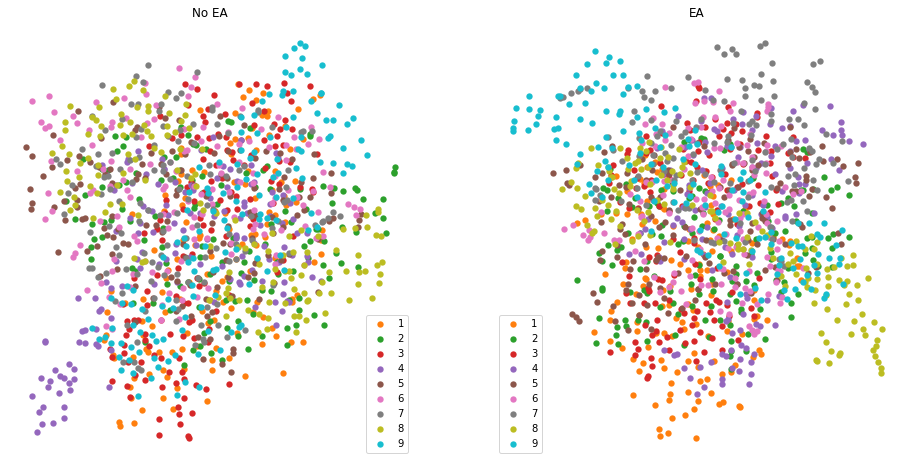

In [48]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for subj in mod_data.keys():
    ax0.set_title('No EA')
    ax0.scatter(mod_data[subj]['sne'][:, 0], mod_data[subj]['sne'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('EA')
    ax1.scatter(mod_data[subj]['sne_EA'][:, 0], mod_data[subj]['sne_EA'][:, 1], lw=0, s=40, color=palette[subj], label=subj)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

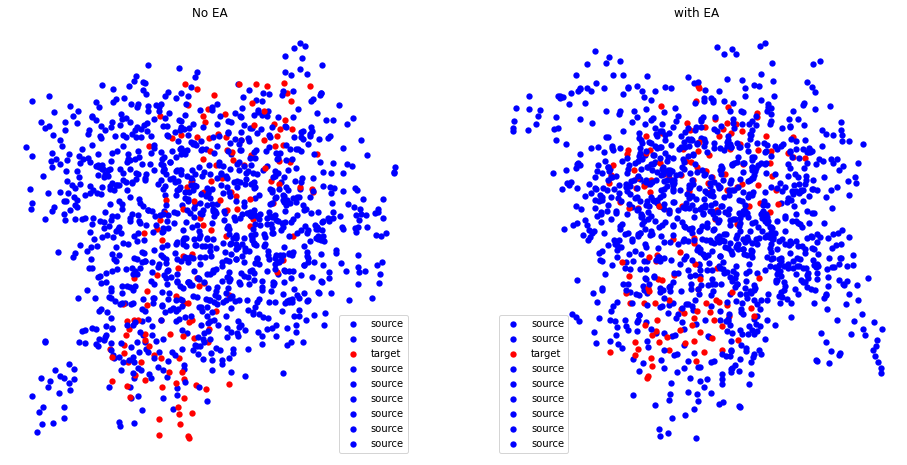

In [49]:
# target vs subject
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for subj in mod_data.keys():
    ax0.set_title('No EA')
    tgt_subj = 3
    if subj == tgt_subj:
        ax0.scatter(mod_data[subj]['sne'][:, 0], mod_data[subj]['sne'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(mod_data[subj]['sne'][:, 0], mod_data[subj]['sne'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if subj == tgt_subj:
        ax1.scatter(mod_data[subj]['sne_EA'][:, 0], mod_data[subj]['sne_EA'][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(mod_data[subj]['sne_EA'][:, 0], mod_data[subj]['sne_EA'][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')
    
plt.savefig('SNE_plot.png')

### Is CSP feat from aligned raw equal to Identity?

In [50]:
# Pick one feature from any subject
all_feats = mod_data[1]['all_feats']

# all_feats.shape
summ=0

cov = np.cov(all_feats, rowvar=False)
dframe(np.round(cov, 3))
# for tr in all_feats:
#     tr = tr[:, None]
#     summ += np.cov(tr, rowvar=True)
    
# I = summ/all_feats.shape[0]
#     I = pd.DataFrame(np.round(I, 2))
    
# I

,0,1,2,3,4,5
0,0.026,0.013,0.010,0.004,0.003,-0.017
1,0.013,0.025,0.010,0.004,0.001,-0.015
2,0.010,0.010,0.023,0.011,0.009,-0.017
3,0.004,0.004,0.011,0.033,0.026,-0.005
4,0.003,0.001,0.009,0.026,0.031,-0.004
5,-0.017,-0.015,-0.017,-0.005,-0.004,0.028


In [51]:
# Pick one feature from any subject
all_feats = mod_data[1]['all_feats_EA']

# all_feats.shape
summ=0

cov = np.cov(all_feats, rowvar=False)
dframe(np.round(cov, 3))

,0,1,2,3,4,5
0,0.027,0.013,0.013,0.005,0.005,-0.018
1,0.013,0.025,0.013,0.004,0.002,-0.016
2,0.013,0.013,0.029,0.014,0.013,-0.015
3,0.005,0.004,0.014,0.033,0.027,-0.006
4,0.005,0.002,0.013,0.027,0.033,-0.004
5,-0.018,-0.016,-0.015,-0.006,-0.004,0.026


In [52]:
print('EA')
print(mod_data[3]['all_feats'][:5])
print('\nWithout EA')
print(mod_data[3]['all_feats_EA'][:5])

EA
[[-1.21788275 -0.50757481 -0.56132825 -0.9275039  -1.02122505 -0.85167355]
 [-1.24120212 -0.56115578 -1.01421809 -0.76961542 -0.87421235 -0.57255285]
 [-1.26277011 -0.61770205 -0.87708476 -0.66860061 -0.78837342 -0.71163885]
 [-0.68307685 -0.58404129 -0.6934714  -0.97188395 -1.13522049 -0.82543693]
 [-1.02537697 -0.57683716 -0.83387756 -0.81018353 -0.83111665 -0.7171896 ]]

Without EA
[[-1.15867413 -0.7411442  -0.39703582 -0.92076231 -0.91171436 -0.97583203]
 [-1.14249112 -0.75522279 -0.81042328 -0.72337144 -0.72519928 -0.65720894]
 [-1.19052334 -0.83823328 -0.69975418 -0.64882086 -0.66582458 -0.82275918]
 [-0.62410363 -0.81784607 -0.52941436 -0.96537775 -1.02594519 -0.9498308 ]
 [-0.95205076 -0.79628896 -0.65546754 -0.78932435 -0.70748837 -0.82723049]]


### Comparing feature distribution of not-aligned vs aligned raw EEG

In [53]:
from sklearn.manifold import TSNE

In [54]:
X_EA = np.array([])
X = np.array([])

list_subj = []

for subj in mod_data.keys():
    print('Processing subject: ', subj)
    feat_EA = mod_data[subj]['train_EA']['feat_train'][:, :-1]
    feat = mod_data[subj]['train']['feat_train'][:, :-1]

    if (len(X) == 0) or (len(X_EA) == 0):
        X = feat
        X_EA = feat_EA
    else:
        X = np.vstack([X, feat])
        X_EA = np.vstack([X_EA, feat])
        
    list_subj.append([subj]*len(feat))
    
list_subj = np.array(list_subj).ravel()
X_sne = TSNE(n_iter=1000).fit_transform(X)
X_sne_EA = TSNE(n_iter=1000).fit_transform(X_EA)

Processing subject:  1
Processing subject:  2
Processing subject:  3
Processing subject:  4
Processing subject:  5
Processing subject:  6
Processing subject:  7
Processing subject:  8
Processing subject:  9


In [55]:
print(X_sne.shape)
print(X_sne_EA.shape)

(1044, 2)
(1044, 2)


In [56]:
# Define palette
import seaborn as sns

In [57]:
palette = np.array(sns.color_palette(palette='bright', n_colors=10))

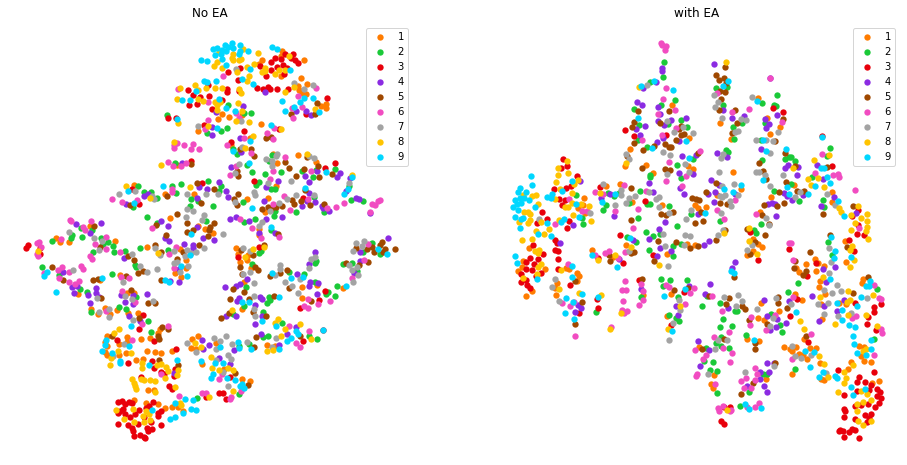

In [58]:
# Distribution of all subjects
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=palette[i], label=i)
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

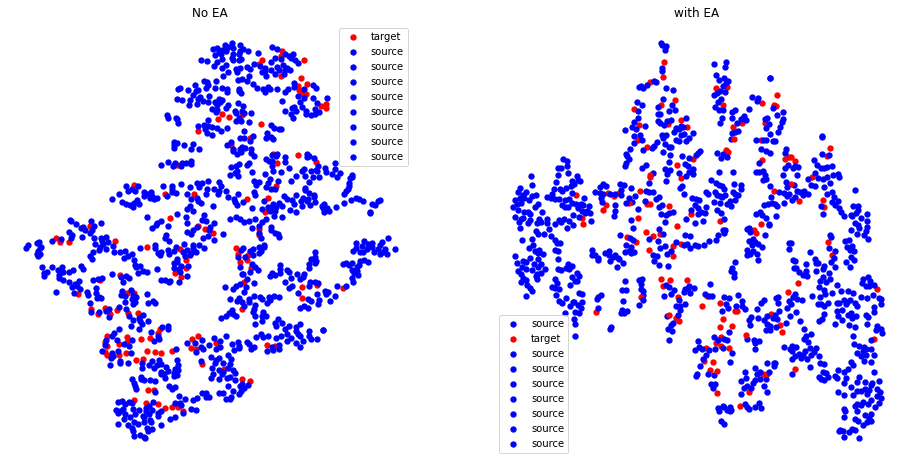

In [59]:
# Let's set the subject 1 as target
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 8))

colorlist = {
    'tgt' : 'red',
    'src' : 'blue'
}

for i in np.unique(list_subj):
    ax0.set_title('No EA')
    if i == 1:
        ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax0.scatter(X_sne[list_subj==i][:, 0], X_sne[list_subj==i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax0.legend()
    ax0.axis('off')
    ax0.axis('tight')
    
    ax1.set_title('with EA')
    if i == 2:
        ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=colorlist['tgt'], label='target')
    else:
        ax1.scatter(X_sne_EA[list_subj==i][:, 0], X_sne_EA[list_subj==i][:, 1], lw=0, s=40, color=colorlist['src'], label='source')
    ax1.legend()
    ax1.axis('off')
    ax1.axis('tight')

plt.show()

### See if all raw_EEG_EA covariance add up to identity matrix

In [60]:
# FOR SEPARATED LEFT AND RIGHT
# Stack all trials of left and right of all subjects
all_trials = np.array([])
all_trials_EA = np.array([])

for subj in mod_data.keys():
    # left and right of each subject
    left = mod_data[subj]['EEG_left']
    right = mod_data[subj]['EEG_right']
    
    left_EA = mod_data[subj]['EEG_left_EA']
    right_EA = mod_data[subj]['EEG_right_EA']
    
    # Stack them together
    both = np.concatenate([left, right], axis=0)
    both_EA = np.concatenate([left_EA, right_EA], axis=0)
    
    # Add to all_trials
    if ((len(all_trials)) or (len(all_trials_EA))) == 0:
        print('creating stack...')
        all_trials = both
        all_trials_EA = both_EA
    else:
        print('adding stack...')
        all_trials = np.concatenate([all_trials, both], axis=0)
        all_trials_EA = np.concatenate([all_trials_EA, both_EA], axis=0)

        
print('In total all trials non-EA in shape of: ', all_trials.shape)
print('In total all trials EA in shape of: ', all_trials_EA.shape)

creating stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
adding stack...
In total all trials non-EA in shape of:  (1296, 22, 750)
In total all trials EA in shape of:  (1296, 22, 750)


In [61]:
# Covariance of all trial
summ == 0
count = 0 
for t in all_trials_EA:
    count += 1
    cov = np.cov(t, rowvar=True, ddof=0)
    summ += cov
    
print(count)
summ = summ/all_trials_EA.shape[0]
dframe(np.round(summ))

1296


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,...,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0
1,-0.0,1.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0,-0.0,...,0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0
2,-0.0,0.0,1.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
3,0.0,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0
4,-0.0,-0.0,-0.0,-0.0,1.0,-0.0,-0.0,0.0,0.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
5,-0.0,0.0,-0.0,0.0,-0.0,1.0,0.0,-0.0,-0.0,-0.0,...,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0
6,-0.0,-0.0,-0.0,0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,...,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0
7,0.0,0.0,-0.0,-0.0,0.0,-0.0,-0.0,1.0,-0.0,0.0,...,0.0,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0
8,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,1.0,-0.0,...,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,-0.0
9,0.0,-0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,1.0,...,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,0.0


In [62]:
# FOR NON-SEPARATED LEFT AND RIGHT
# Stack all trials of left and right of all subjects
all_trials = np.array([])
all_trials_EA = np.array([])

for subj in mod_data.keys():
    print('Subject {}'.format(subj))
    # left and right of each subject
    both = mod_data[subj]['all_trials']
    both_EA = mod_data[subj]['all_trials_EA']
    
    # Add to all_trials
    if ((len(all_trials)) or (len(all_trials_EA))) == 0:
        print('creating stack...')
        all_trials = both
        all_trials_EA = both_EA
    else:
        print('adding stack...')
        all_trials = np.concatenate([all_trials, both], axis=0)
        all_trials_EA = np.concatenate([all_trials_EA, both_EA], axis=0)

        
print('In total all trials non-EA in shape of: ', all_trials.shape)
print('In total all trials EA in shape of: ', all_trials_EA.shape)

Subject 1
creating stack...
Subject 2
adding stack...
Subject 3
adding stack...
Subject 4
adding stack...
Subject 5
adding stack...
Subject 6
adding stack...
Subject 7
adding stack...
Subject 8
adding stack...
Subject 9
adding stack...
In total all trials non-EA in shape of:  (1296, 22, 750)
In total all trials EA in shape of:  (1296, 22, 750)


In [63]:
# Covariance of all trial
summ == 0
count = 0 
for t in all_trials_EA:
    count += 1
    cov = np.cov(t, rowvar=True, ddof=0)
    summ += cov
    
print(count)
summ = summ/all_trials_EA.shape[0]
# dframe(np.round(summ))
summ.sum().sum()

1296


21.987619341564372

# EA + Weighted TL

## Define target and source subjects

In [64]:
# Create CSP feat algorithm that can split into train and test set 
from sklearn.model_selection import train_test_split

def csp_feat_ver4(data, n_filter=3, train_size=50, key='all_trials'):
    '''
    This function will accept all trials of one subject then split then into train and test size
    Defult is set to give train_size of 50 samples
    '''
    X = data[key]
    y = data['y']

    # Split them into train and test set
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, train_size=train_size, shuffle=True, random_state=42)

    EEG_left = X_tr[y_tr==0]
    EEG_right = X_tr[y_tr==1]

    # Covariance of left and right
    cov_left = 0
    for signal in EEG_left:
        cov_left += np.cov(signal, rowvar=True, ddof=1)

    cov_left = cov_left/EEG_left.shape[0]

    cov_right = 0
    for signal in EEG_right:
        cov_right += np.cov(signal, rowvar=True, ddof=1)

    cov_right = cov_right/EEG_right.shape[0]

    # Matrix left division (adopted from MATLAB)
    mldiv = la.lstsq(cov_right, cov_left, rcond=None)[0]

    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)

    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]

    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)

    # Calculating feature train and test
    feat_train = []
    feat_test = []

    for trial_train in X_tr:
        X = W.T@trial_train
        feat_train.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 

    for trial_test in X_te:
        X = W.T@trial_test
        feat_test.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 
        
    return np.array(feat_train), np.array(feat_test), X_tr, X_te, y_tr, y_te

In [65]:
# Define data necessary for target and source subject
TL_data = {}
TL_data['tgt'] = {}
TL_data['src'] = {}

# As target data with only 10 trials, 5 each class
for subj in mod_data.keys():
    TL_data['tgt'][subj] = {}
    TL_data['src'][subj] = {}
    print('Creating target and source data for subject {}'.format(subj))
    # TARGET
    target = TL_data['tgt'][subj]
    
    print('For Non-EA data')
    # Split all trials of a subject into training and test set
    target['feat_train'], target['feat_test'], target['XtrRaw'], target['XteRaw'], target['ytr'], target['yte'] = csp_feat_ver4(mod_data[subj],
                                                                                                                                n_filter=3,
                                                                                                                                train_size=50,
                                                                                                                                key='all_trials')
    
    print('For EA data')
    # Also the same for EA raw data
    target['feat_train_EA'], target['feat_test_EA'], target['XtrRaw_EA'], target['XteRaw_EA'], target['ytr_EA'], target['yte_EA'] = csp_feat_ver4(mod_data[subj],
                                                                                                                                    n_filter=3,
                                                                                                                                    train_size=50,
                                                                                                                                    key='all_trials_EA')
    
    
    # SOURCE
    source = TL_data['src'][subj]
    
    print('Create csp features when acts as a source non-EA and EA')
    # This will store whole trials when `subj` acts as a source
    source['feat_train'] = csp_feat_ver3(mod_data[subj], n_filter=3, key='all_trials')
    source['feat_train_EA'] = csp_feat_ver3(mod_data[subj], n_filter=3, key='all_trials_EA')

    source['y'] = deepcopy(mod_data[subj]['y'])
    

Creating target and source data for subject 1
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 2
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 3
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 4
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 5
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 6
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 7
For Non-EA data
For EA data
Create csp features when acts as a source non-EA and EA
Creating target and source data for subject 8
For Non-EA data
For EA data
Create csp featu

In [66]:
TL_data['tgt'][1].keys()

dict_keys(['feat_train', 'feat_test', 'XtrRaw', 'XteRaw', 'ytr', 'yte', 'feat_train_EA', 'feat_test_EA', 'XtrRaw_EA', 'XteRaw_EA', 'ytr_EA', 'yte_EA'])

## Model 1:  SVM (Baseline)

In [67]:
# Create a function that can run stratified 5-fold cv on SVM model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def model_svm(data, cv=5):
    '''
    Run SVM model , do cv-fold feat_train, this will only apply to one subject
    Then test the model on test set
    
    Return:
    Accuracy +/- std
    '''
    # Pick the training feature and test 
    Xtr = data['feat_train']
    ytr = data['ytr']
    Xte = data['feat_test']
    yte = data['yte']
    
    # Stratified KFold instance
    skf = StratifiedKFold(n_splits=5)
    
    # List to store score each cv    
    score_tr = []
    score_te = 0
    best_sc = 0

    for idx_te, idx_tr in skf.split(Xtr, ytr):
        assert len(idx_tr) == 10
        
        # Define model each cv iteration (no hp-tuning)
        model = SVC()
        
        # Fit the model, obtain train score on n-1 fold
        model.fit(Xtr[idx_tr], ytr[idx_tr])
        curr_sc = model.score(Xtr[idx_te], ytr[idx_te])
        
        # Index that gives best training result
        if best_sc < curr_sc:
            # print('found')
            best_sc = curr_sc
            best_idx_tr = idx_tr

        score_tr.append(curr_sc)
    
    # Define model (no hp-tuning)
    model = SVC()
    
    # Refit model to best idx for train
    model.fit(Xtr[best_idx_tr], ytr[best_idx_tr])
        
    # Test score using Xte and yte
    score_te = model.score(Xte, yte)
    
    # Store everything back into data
    data['score_tr_svm'] = np.mean(score_tr)
    data['score_std_svm'] = np.std(score_tr)
    data['score_te_svm'] = score_te

In [68]:
# Iterate over all data and compute svm on training data
for subj in TL_data['tgt'].keys():
    model_svm(TL_data['tgt'][subj])

## Model 2: Weighted-LTL

In [69]:
# Define all necessary function, all of these are imported from weighted-LTL notebook
from sklearn.base import BaseEstimator, ClassifierMixin

class LogReg_TL(BaseEstimator):
    def __init__(self, learningRate=1e-5, num_iter=100, penalty=None, intercept = True,\
                 lambd=1, ETL=np.array([[0, 0],[0, 0]]), mu=0):
        
        self.learningRate = learningRate
        self.num_iter = num_iter
        self.penalty = penalty
        self.intercept = intercept
        self.ETL = ETL
        self.lambd = lambd
        self.mu = mu
        
    def __sigmoid(self, z):
        return 1/(1 + np.exp(-z))
    
    def __logLL(self, z, y):
        return -1 * np.sum((y * np.log10(self.__sigmoid(z))) + ((1 - y) * np.log10(1 - self.__sigmoid(z))))

    def __reg_logLL1(self, z, y, weights):
        reg = 0.5 * self.lambd * np.sum(np.dot(weights, weights))
        
        return (-1 * np.sum((y * np.log10(self.__sigmoid(z))) + ((1 - y) * np.log10(1 - self.__sigmoid(z)))) ) + reg
    
    def __reg_logLL2(self, z, y, weights):
        ETL_det = np.log10(np.linalg.det(self.ETL))
        
        reg = 0.5 * self.lambd * np.sum( ((weights-self.mu)**2)@self.ETL) + ETL_det 

        return (-1 * np.sum((y * np.log10(self.__sigmoid(z))) + ((1 - y) * np.log10(1 - self.__sigmoid(z)))) ) + reg
        
    def fit(self, X_train, y_train):
        self.weights = np.zeros(np.shape(X_train)[1] + 1) 
        
        if self.intercept:
            X_train = np.c_[np.ones([np.shape(X_train)[0], 1]), X_train]
        
        self.costs = []
        
        for i in range(self.num_iter):
            z = np.dot(X_train, self.weights)
            err = -y_train + self.__sigmoid(z)
            
            if self.penalty == 'L1':
                if i == 0:
                    print(self.penalty)
                    
                delta_w = np.dot(err, X_train)

                # weight update
                self.weights += -self.learningRate * delta_w
                self.weights[1:] += -self.learningRate * self.lambd * self.weights[1:]
                
                # costs
                self.costs.append(self.__reg_logLL1(z, y_train, self.weights))
                
            elif (self.penalty == 'L2') and (np.all(self.mu)) :
                if i == 0:
                    print(self.penalty)
                
                delta_w = np.dot(err, X_train)
                
                # weight update
                self.weights += -self.learningRate * delta_w
                self.weights[1:] += -self.learningRate * self.lambd * ((self.weights - self.mu)@(np.linalg.inv(self.ETL)) )[1:]
            
                # cost
                self.costs.append(self.__reg_logLL2(z, y_train, self.weights))
                
            else:
                if i == 0:
                    print(self.penalty)
                    
                delta_w = -self.learningRate * np.dot(err, X_train)
                
                # weight update
                self.weights += delta_w    
                
                # cost
                self.costs.append(self.__logLL(z, y_train))
                
            if i % 30000 == 0:
                print('weights: ',np.round(self.weights, 3))
                
            
        return self
    
    def predict_proba(self, X):
        return self.__sigmoid((X @ self.weights[1:]) + self.weights[0])
        
    def predict(self, X):
        return np.round(self.predict_proba(X))
    
    def score(self, X, y):
        y_pred = self.predict(X)
        scores = ((y==y_pred)*1).mean()
        
        return scores

### Compute the clf params (ws) of each subject when serves as source
Model use to train data is:
$$L_1(w_s) = min (\sum_{i=1}^{n_s}H(w_s;y_s^i, x_s^i + \lambda_s||w_s||^2_2)$$

In [70]:
def build_clf_params(data):
    # Where the tranining data is stored
    X = data['feat_train']
    y = data['y']
    
    # Use this model when training subject as source 
    model_L1 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L1', lambd=1)
    
    # Fit model and store weight
    model_L1.fit(X, y)
    data['ws'] = model_L1.weights

In [71]:
# Iterate over all source subject to compute weights
for subj in TL_data['src'].keys():
    print('Processing weight subject ', subj)
    build_clf_params(TL_data['src'][subj]) 

Processing weight subject  1
L1
weights:  [ 0.    -0.003 -0.003 -0.004  0.003  0.004  0.004]
Processing weight subject  2
L1
weights:  [ 0.    -0.003 -0.001 -0.001  0.002  0.003  0.004]
Processing weight subject  3
L1
weights:  [ 0.    -0.01  -0.004 -0.002  0.003  0.004  0.007]
Processing weight subject  4
L1
weights:  [ 0.    -0.003 -0.003 -0.002  0.002  0.003  0.001]
Processing weight subject  5
L1
weights:  [ 0.    -0.004 -0.004 -0.004  0.002  0.002  0.002]
Processing weight subject  6
L1
weights:  [ 0.    -0.003 -0.002 -0.002  0.002  0.003  0.002]
Processing weight subject  7
L1
weights:  [ 0.    -0.002 -0.003 -0.001  0.003  0.003  0.005]
Processing weight subject  8
L1
weights:  [ 0.    -0.008 -0.003 -0.     0.007  0.008  0.017]
Processing weight subject  9
L1
weights:  [ 0.    -0.006 -0.006 -0.006  0.002  0.005  0.011]


### KL divergence of each target to all source subjects

In [72]:
# First define the kl divergence
def KL_div(P, Q):
    # First convert to np array
    P = np.array(P)
    Q = np.array(Q)
    
    # Then compute their means, datain shape of samples x feat
    mu_P = np.mean(P, axis=0)
    mu_Q = np.mean(Q, axis=0)    
    
    # Compute their covariance
    cov_P = np.cov(P, rowvar=False)
    cov_Q = np.cov(Q, rowvar=False)    
        
    cov_Q_inv = np.linalg.inv(cov_Q)
    
    # Compute KL divergence
    KL_div = np.log(np.linalg.det(cov_Q)/np.linalg.det(cov_P)) - mu_P.shape[0] + np.trace(cov_Q_inv@cov_P) + \
                (mu_P - mu_Q).T@cov_Q_inv@(mu_P - mu_Q)
    
    KL_div = 0.5 * KL_div
    
    return KL_div

In [73]:
TL_data['src'][1].keys()

dict_keys(['feat_train', 'feat_train_EA', 'y', 'ws'])

In [74]:
# Compute kl divergence of target subject to each source subject
def compute_all_kl_div(data):
    '''
    Parameter:
    data, is the whole data containing target and source data
    '''
    
    # Iterate over all subject
    for tgt_subj in data['tgt'].keys():
        kl_div_score = []
        
        print('=== Current target subject %02d === ' %tgt_subj)
        # Separate into left and right class
        yP = data['tgt'][tgt_subj]['ytr']
        P_left = data['tgt'][tgt_subj]['feat_train'][yP==0]
        P_right = data['tgt'][tgt_subj]['feat_train'][yP==1]
        
        
        for src_subj in data['src'].keys():    
            print('KL div with respect to source subject', src_subj)
            
            # Separate into left and right class
            yQ = data['src'][src_subj]['y']
            Q_left = data['src'][src_subj]['feat_train'][yQ==0]
            Q_right = data['src'][src_subj]['feat_train'][yQ==1]
            
            # Compute kl div of each class, average, then append them
            kl_left = KL_div(P_left, Q_left)
            kl_right = KL_div(P_right, Q_right)
            kl_div = (kl_left + kl_right)/2
            kl_div_score.append(kl_div)
            
        # Zeroing source subject that acts as curetn target
        kl_div_score[tgt_subj-1] = 0    
            
        # Store them back into current target subject
        data['tgt'][tgt_subj]['kl_div'] = kl_div_score

In [75]:
compute_all_kl_div(TL_data)

=== Current target subject 01 === 
KL div with respect to source subject 1
KL div with respect to source subject 2
KL div with respect to source subject 3
KL div with respect to source subject 4
KL div with respect to source subject 5
KL div with respect to source subject 6
KL div with respect to source subject 7
KL div with respect to source subject 8
KL div with respect to source subject 9
=== Current target subject 02 === 
KL div with respect to source subject 1
KL div with respect to source subject 2
KL div with respect to source subject 3
KL div with respect to source subject 4
KL div with respect to source subject 5
KL div with respect to source subject 6
KL div with respect to source subject 7
KL div with respect to source subject 8
KL div with respect to source subject 9
=== Current target subject 03 === 
KL div with respect to source subject 1
KL div with respect to source subject 2
KL div with respect to source subject 3
KL div with respect to source subject 4
KL div with res

In [76]:
# Sanity check
TL_data['tgt'][1]['kl_div']

[0,
 34.55120319529902,
 6.352021779142478,
 46.386777955157825,
 13.246420177048066,
 27.851463549094486,
 45.16346088926002,
 183.8223412876104,
 43.871485514840245]

### Similarity weights `a_s`

In [77]:
def compute_similarity_weights(kl):
    KL_inv =[]
    eps = 1e-2
    
    for val in kl:
        if val != 0: 
            KL_inv.append(1/(val + eps**4))
        
    a_s = []
    
    for inv_val in KL_inv:
        temp = inv_val/sum(KL_inv)    
        a_s.append(temp)
        
        #print('Similarity weight {:.3f}'.format(temp))
        
    return a_s

In [78]:
# Compute similarity weighst of all target subject
for tgt_subj in TL_data['tgt'].keys():
    kl = TL_data['tgt'][tgt_subj]['kl_div']
    TL_data['tgt'][tgt_subj]['a_s'] = compute_similarity_weights(kl)

### `E_TL` Algorithm

In [79]:
# Define algorithm to compute ETL

def compute_ETL_and_mu_ws(data):
    '''
    NOTE THAT THIS CODE IS FOR WEIGHTED LTL, THIS USE a_s, weights of similarity from kl_div
    Parameter:
    data: contains data of all target and source subjects
    '''
    print('===== Computing ETL and mu_ws =======')
    # Will compute the ETL of each target subject
    for tgt_subj in data['tgt'].keys():
        print('=== Target subject %d ====' %tgt_subj)
        src_subj = [i for i in data['src'].keys() if i != tgt_subj]
            
        # First compute the mean of all source weights 'mu_ws' over all subjects
        all_ws = []
        
        # similarity weights a_s of current target
        a_s = data['tgt'][tgt_subj]['a_s']
        
        for a, s_subj in zip(a_s, src_subj):
            print('Gathering weights from source subject', s_subj)
            ws = TL_data['src'][s_subj]['ws']
            ws = a * ws
            all_ws.append(ws)

        # Average of ws over all subjects, axis=0
        mu_ws = np.mean(np.array(all_ws), axis=0)
        
        # This will add up all ws - mu_ws, to compute ETL
        temp_ws = 0
        for a, s_subj in zip(a_s, src_subj):
            ws = TL_data['src'][s_subj]['ws']
            ws_min_mu = (a*ws - mu_ws)[:, None] @ (a*ws - mu_ws)[None, :]
            temp_ws += ws_min_mu

        # Compute ETL, only contain diagonal element with zero elements to rest of elements
        den = np.diag(temp_ws)
        nom = np.trace(temp_ws)
        ETL = np.diag(den/nom)

        data['tgt'][tgt_subj]['ETL'] = ETL
        data['tgt'][tgt_subj]['mu_ws'] = mu_ws

In [80]:
compute_ETL_and_mu_ws(TL_data)

===== Computing ETL and mu_ws =======
=== Target subject 1 ====
Gathering weights from source subject 2
Gathering weights from source subject 3
Gathering weights from source subject 4
Gathering weights from source subject 5
Gathering weights from source subject 6
Gathering weights from source subject 7
Gathering weights from source subject 8
Gathering weights from source subject 9
=== Target subject 2 ====
Gathering weights from source subject 1
Gathering weights from source subject 3
Gathering weights from source subject 4
Gathering weights from source subject 5
Gathering weights from source subject 6
Gathering weights from source subject 7
Gathering weights from source subject 8
Gathering weights from source subject 9
=== Target subject 3 ====
Gathering weights from source subject 1
Gathering weights from source subject 2
Gathering weights from source subject 4
Gathering weights from source subject 5
Gathering weights from source subject 6
Gathering weights from source subject 7
Gath

In [81]:
# Sanity check
for s in TL_data['tgt'].keys():
    assert 'ETL' in TL_data['tgt'][1].keys()
    assert 'mu_ws' in TL_data['tgt'][1].keys()

### Train + test score

In [82]:
def model_weighted_LTL(data):
    '''
    data: data containing one target subject, currently data = TL_data['tgt'][tgt_subj_no]
    
    '''
    # Create stratified KFold instance
    skf = StratifiedKFold(n_splits=5)

    # Grab the train data of current target subject
    Xtr = data['feat_train']
    ytr = data['ytr']
    Xte = data['feat_test']
    yte = data['yte']

    #print(Xtr.shape)
    #print(ytr.shape)

    # Then also defines the ETL and mu_ws
    ETL = data['ETL']
    mu_ws = data['mu_ws']

    score_tr = []
    best_score = 0

    # Do k-fold cv using stratified kfold, will train on 10 samples:
    for i, (idx_te, idx_tr) in enumerate(skf.split(Xtr, ytr)):
        print('processing cv-', i+1)
        
        # Make sure there are 10 train index
        assert len(idx_tr) == 10
        assert (ytr[idx_tr] == 1).sum() == 5

        # Define new model each iteration, so that weights is newly initialized
        model_L2 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L2', lambd=1, ETL=ETL, mu=mu_ws)

        # Fit model into ten training samples samples
        _ = model_L2.fit(Xtr[idx_tr], ytr[idx_tr])

        # Evaluate on n-1 folds of training samples
        curr_score = model_L2.score(Xtr[idx_te], ytr[idx_te])
        score_tr.append(curr_score)
        
        print('best score:', best_score)
        print('curr score:', curr_score)
        
        if best_score < curr_score:
            print('found best')
            best_score = curr_score
            best_idx_tr = idx_tr

    # Fit model using the best train index, obtain test score
    model_L2 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L2', lambd=1, ETL=ETL, mu=mu_ws)

    _ = model_L2.fit(Xtr[best_idx_tr], ytr[best_idx_tr])
    score_te = model_L2.score(Xte, yte)   

    return np.mean(np.array(score_tr)), np.std(np.array(score_tr)), score_te

In [83]:
# for subj in TL_data.keys():
for tgt_subj in TL_data['tgt'].keys():
    print('=== Processing target subject %02d ====' %tgt_subj)
    temp_tgt = TL_data['tgt'][tgt_subj]
    temp_tgt['score_tr_wLTL'], temp_tgt['score_std_wLTL'], temp_tgt['score_te_wLTL'] = model_weighted_LTL(TL_data['tgt'][tgt_subj])

=== Processing target subject 01 ====
processing cv- 1
L2
weights:  [ 0.    -0.001 -0.003 -0.004  0.003  0.007  0.001]
best score: 0
curr score: 0.7
found best
processing cv- 2
L2
weights:  [ 0.    -0.001 -0.003 -0.004  0.003  0.007  0.001]
best score: 0.7
curr score: 0.875
found best
processing cv- 3
L2
weights:  [ 0.    -0.001 -0.003 -0.005  0.004  0.007  0.001]
best score: 0.875
curr score: 0.825
processing cv- 4
L2
weights:  [ 0.    -0.001 -0.003 -0.004  0.003  0.007  0.001]
best score: 0.875
curr score: 0.925
found best
processing cv- 5
L2
weights:  [ 0.    -0.001 -0.003 -0.004  0.003  0.007  0.001]
best score: 0.925
curr score: 0.725
L2
weights:  [ 0.    -0.001 -0.003 -0.004  0.003  0.007  0.001]
=== Processing target subject 02 ====
processing cv- 1
L2
weights:  [ 0.    -0.002 -0.002 -0.002  0.001  0.002  0.002]
best score: 0
curr score: 0.7
found best
processing cv- 2
L2
weights:  [ 0.    -0.002 -0.002 -0.002  0.002  0.002  0.001]
best score: 0.7
curr score: 0.775
found best
pr

## Model 3: EA + SVM

In [84]:
# Quick check to see non_EA and EA feature are different
print(TL_data['tgt'][2]['feat_train'][:3])
print('')
print(TL_data['tgt'][2]['feat_train_EA'][:3])

[[-0.53571013 -0.73466716 -0.67494852 -0.7770544  -1.19359456 -1.08607868]
 [-0.65485842 -0.85601369 -0.8275193  -0.71355048 -0.95547716 -0.72965576]
 [-0.64846913 -0.72100024 -0.75458933 -0.83812169 -1.26244031 -0.67891069]]

[[-0.63014919 -0.80520812 -0.69352183 -0.79038294 -0.86562411 -0.96564274]
 [-0.79395804 -0.97121521 -0.89075318 -0.77153958 -0.67216728 -0.65388039]
 [-0.76178158 -0.81041459 -0.79203604 -0.87032362 -0.95334326 -0.57734814]]


In [85]:
# Sanity check to see diagonal of raw_EA data equal to I matrix
# Stack all training trials of all subjects
all_trials = np.array([])
all_trials_EA = np.array([])

for subj in TL_data['tgt'].keys():
    print('Subject {}'.format(subj))
    # left and right of each subject
    both = TL_data['tgt'][subj]['XtrRaw']
    both_EA = TL_data['tgt'][subj]['XtrRaw_EA']
    
    # Add to all_trials
    if ((len(all_trials)) or (len(all_trials_EA))) == 0:
        #print('creating stack...')
        all_trials = both
        all_trials_EA = both_EA
    else:
        #print('adding stack...')
        all_trials = np.concatenate([all_trials, both], axis=0)
        all_trials_EA = np.concatenate([all_trials_EA, both_EA], axis=0)

        
print('In total all trials non-EA in shape of: ', all_trials.shape)
print('In total all trials EA in shape of: ', all_trials_EA.shape)

# Covariance of all trial
summ == 0
count = 0 
for t in all_trials_EA:
    count += 1
    cov = np.cov(t, rowvar=True, ddof=0)
    summ += cov
    
print('\nTotal trial:', count)
summ = summ/count
# dframe(np.round(summ))
print('All diagonal data: %.3f must be close to 22' %np.diag(summ).sum())

Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
In total all trials non-EA in shape of:  (450, 22, 750)
In total all trials EA in shape of:  (450, 22, 750)

Total trial: 450
All diagonal data: 21.869 must be close to 22


In [86]:
# Create a function that can run stratified 5-fold cv on EA + SVM model
def model_svm_EA(data, cv=5):
    '''
    Run SVM model , do cv-fold feat_train, this will only apply to one subject
    Then test the model on test set
    
    Return:
    Accuracy +/- std
    '''
    # Pick the EA training and test feature 
    Xtr = data['feat_train_EA']
    ytr = data['ytr_EA']
    Xte = data['feat_test_EA']
    yte = data['yte_EA']
    
    # Stratified KFold instance
    skf = StratifiedKFold(n_splits=5)
    
    # List to store score each cv    
    score_tr = []
    score_te = 0
    best_sc = 0

    for idx_te, idx_tr in skf.split(Xtr, ytr):
        assert len(idx_tr) == 10
        
        # Define model each cv iteration(no hp-tuning)
        model = SVC()
        
        # Fit the model, obtain train score on n-1 fold
        model.fit(Xtr[idx_tr], ytr[idx_tr])
        curr_sc = model.score(Xtr[idx_te], ytr[idx_te])
        
        # Index that gives best training result
        if best_sc < curr_sc:
            # print('found')
            best_sc = curr_sc
            best_idx_tr = idx_tr

        score_tr.append(curr_sc)
    
    # Define model (initial experiment, no hp-tuning)
    model = SVC()    
    
    # Refit model to best idx for train
    model.fit(Xtr[best_idx_tr], ytr[best_idx_tr])
        
    # Test score using Xte and yte
    score_te = model.score(Xte, yte)
    
    # Store everything back into data
    data['score_tr_svm_EA'] = np.mean(score_tr)
    data['score_std_svm_EA'] = np.std(score_tr)
    data['score_te_svm_EA'] = score_te

In [87]:
# Iterate over all data and compute svm_EA on training data
for subj in TL_data['tgt'].keys():
    model_svm_EA(TL_data['tgt'][subj])

In [88]:
TL_data['tgt'][1]['score_tr_svm_EA']

0.82

## Model 4: EA + Weighted-LTL

### Compute the clf params (ws) of each subject
Model use to train data is:
$$L_1(w_s) = min (\sum_{i=1}^{n_s}H(w_s;y_s^i, x_s^i + \lambda_s||w_s||^2_2)$$

In [89]:
def build_clf_params_EA(data):
    # Where the tranining data is stored
    X = data['feat_train_EA']
    y = data['y']
    
    # Use this model when training subject as source 
    model_L1 = LogReg_TL(learningRate=5e-3, num_iter=50000, penalty='L1', lambd=1)
    
    # Fit model and store weight
    model_L1.fit(X, y)
    data['ws_EA'] = model_L1.weights

In [90]:
# Iterate over all source subject to compute weights
for subj in TL_data['src'].keys():
    print('Processing weight subject ', subj)
    build_clf_params_EA(TL_data['src'][subj]) 

Processing weight subject  1
L1
weights:  [ 0.    -0.016 -0.018 -0.022  0.013  0.018  0.015]
weights:  [-0.402 -1.055 -1.184 -2.407  1.233  1.916  0.843]
Processing weight subject  2
L1
weights:  [ 0.    -0.016 -0.01  -0.008  0.005  0.012  0.015]
weights:  [-0.222 -1.765 -1.    -0.858  0.803  1.198  1.395]
Processing weight subject  3
L1
weights:  [ 0.    -0.052 -0.02  -0.011  0.017  0.021  0.036]
weights:  [-0.374 -3.547 -1.476 -0.83   1.2    1.03   3.29 ]
Processing weight subject  4
L1
weights:  [ 0.    -0.015 -0.012 -0.01   0.011  0.016  0.005]
weights:  [ 0.171 -1.233 -0.987 -0.794  1.136  1.993 -0.022]
Processing weight subject  5
L1
weights:  [ 0.    -0.014 -0.016 -0.017  0.015  0.015  0.016]
weights:  [-0.893 -0.831 -2.084 -1.312  0.872  1.178  1.193]
Processing weight subject  6
L1
weights:  [ 0.    -0.016 -0.012 -0.011  0.009  0.013  0.008]
weights:  [-0.063 -1.509 -0.827 -1.236  1.064  1.599  0.711]
Processing weight subject  7
L1
weights:  [ 0.    -0.013 -0.017 -0.007  0.01

### KL divergence of each target to all source subjects

In [91]:
TL_data['src'][1].keys()

dict_keys(['feat_train', 'feat_train_EA', 'y', 'ws', 'ws_EA'])

In [92]:
# Compute kl divergence of target subject to each source subject
def compute_all_kl_div_EA(data):
    '''
    Parameter:
    data, is the whole data containing target and source data
    '''
    
    # Iterate over all subject
    for tgt_subj in data['tgt'].keys():
        kl_div_score = []
        
        print('=== Current target subject %02d === ' %tgt_subj)
        # Separate into left and right class
        yP = data['tgt'][tgt_subj]['ytr_EA']
        P_left = data['tgt'][tgt_subj]['feat_train_EA'][yP==0]
        P_right = data['tgt'][tgt_subj]['feat_train_EA'][yP==1]
        
        
        for src_subj in data['src'].keys():    
            print('KL div with respect to source subject', src_subj)
            
            # Separate into left and right class
            yQ = data['src'][src_subj]['y']
            Q_left = data['src'][src_subj]['feat_train_EA'][yQ==0]
            Q_right = data['src'][src_subj]['feat_train_EA'][yQ==1]
            
            # Compute kl div of each class, average, then append them
            kl_left = KL_div(P_left, Q_left)
            kl_right = KL_div(P_right, Q_right)
            kl_div = (kl_left + kl_right)/2
            kl_div_score.append(kl_div)
            
        # Zeroing source subject that acts as curent target
        kl_div_score[tgt_subj-1] = 0    
            
        # Store them back into current target subject
        data['tgt'][tgt_subj]['kl_div_EA'] = kl_div_score

In [93]:
compute_all_kl_div_EA(TL_data)

=== Current target subject 01 === 
KL div with respect to source subject 1
KL div with respect to source subject 2
KL div with respect to source subject 3
KL div with respect to source subject 4
KL div with respect to source subject 5
KL div with respect to source subject 6
KL div with respect to source subject 7
KL div with respect to source subject 8
KL div with respect to source subject 9
=== Current target subject 02 === 
KL div with respect to source subject 1
KL div with respect to source subject 2
KL div with respect to source subject 3
KL div with respect to source subject 4
KL div with respect to source subject 5
KL div with respect to source subject 6
KL div with respect to source subject 7
KL div with respect to source subject 8
KL div with respect to source subject 9
=== Current target subject 03 === 
KL div with respect to source subject 1
KL div with respect to source subject 2
KL div with respect to source subject 3
KL div with respect to source subject 4
KL div with res

In [94]:
# Sanity check
TL_data['tgt'][1]['kl_div_EA']

[0,
 4.093019728839368,
 4.248084705044787,
 4.391211223863289,
 1.6013789017781126,
 4.756948400170708,
 1.3185731307703592,
 3.8152854243584597,
 2.552299152190815]

### Similarity weights `a_s`

In [95]:
# Compute similarity weighst of all target subject
for tgt_subj in TL_data['tgt'].keys():
    kl = TL_data['tgt'][tgt_subj]['kl_div_EA']
    TL_data['tgt'][tgt_subj]['a_s_EA'] = compute_similarity_weights(kl)

In [96]:
TL_data['tgt'][2].keys()

dict_keys(['feat_train', 'feat_test', 'XtrRaw', 'XteRaw', 'ytr', 'yte', 'feat_train_EA', 'feat_test_EA', 'XtrRaw_EA', 'XteRaw_EA', 'ytr_EA', 'yte_EA', 'score_tr_svm', 'score_std_svm', 'score_te_svm', 'kl_div', 'a_s', 'ETL', 'mu_ws', 'score_tr_wLTL', 'score_std_wLTL', 'score_te_wLTL', 'score_tr_svm_EA', 'score_std_svm_EA', 'score_te_svm_EA', 'kl_div_EA', 'a_s_EA'])

### `E_TL` Algorithm

In [97]:
# Define algorithm to compute ETL

def compute_ETL_and_mu_ws_EA(data):
    '''
    NOTE THAT THIS CODE IS FOR WEIGHTED LTL, THIS USE a_s, weights of similarity from kl_div
    Parameter:
    data: contains data of all target and source subjects
    '''
    print('===== Computing ETL and mu_ws EA =======')
    # Will compute the ETL of each target subject
    for tgt_subj in data['tgt'].keys():
        print('=== Target subject %d ====' %tgt_subj)
        src_subj = [i for i in data['src'].keys() if i != tgt_subj]
            
        # First compute the mean of all source weights 'mu_ws' over all subjects
        all_ws = []
        
        # similarity weights a_s of current target
        a_s = data['tgt'][tgt_subj]['a_s_EA']
        
        for a, s_subj in zip(a_s, src_subj):
            print('Gathering weights from source subject', s_subj)
            ws = TL_data['src'][s_subj]['ws_EA']
            ws = a * ws
            all_ws.append(ws)

        # Average of ws over all subjects, axis=0
        mu_ws = np.mean(np.array(all_ws), axis=0)
        
        # This will add up all ws - mu_ws, to compute ETL
        temp_ws = 0
        for a, s_subj in zip(a_s, src_subj):
            ws = TL_data['src'][s_subj]['ws_EA']
            ws_min_mu = (a*ws - mu_ws)[:, None] @ (a*ws - mu_ws)[None, :]
            temp_ws += ws_min_mu

        # Compute ETL, only contain diagonal element with zero elements to rest of elements
        den = np.diag(temp_ws)
        nom = np.trace(temp_ws)
        ETL = np.diag(den/nom)

        data['tgt'][tgt_subj]['ETL_EA'] = ETL
        data['tgt'][tgt_subj]['mu_ws_EA'] = mu_ws

In [98]:
compute_ETL_and_mu_ws_EA(TL_data)

===== Computing ETL and mu_ws EA =======
=== Target subject 1 ====
Gathering weights from source subject 2
Gathering weights from source subject 3
Gathering weights from source subject 4
Gathering weights from source subject 5
Gathering weights from source subject 6
Gathering weights from source subject 7
Gathering weights from source subject 8
Gathering weights from source subject 9
=== Target subject 2 ====
Gathering weights from source subject 1
Gathering weights from source subject 3
Gathering weights from source subject 4
Gathering weights from source subject 5
Gathering weights from source subject 6
Gathering weights from source subject 7
Gathering weights from source subject 8
Gathering weights from source subject 9
=== Target subject 3 ====
Gathering weights from source subject 1
Gathering weights from source subject 2
Gathering weights from source subject 4
Gathering weights from source subject 5
Gathering weights from source subject 6
Gathering weights from source subject 7
G

In [99]:
# Sanity check
for s in TL_data['tgt'].keys():
    assert 'ETL_EA' in TL_data['tgt'][1].keys()
    assert 'mu_ws_EA' in TL_data['tgt'][1].keys()

In [100]:
# Function to evaluate model using weighted LTL on EAed training feature 
def model_weighted_LTL_EA(data):
    '''
    data: data containing one target subject, currently data = TL_data['tgt'][tgt_subj_no]
    
    '''
    # Create stratified KFold instance
    skf = StratifiedKFold(n_splits=5)
    print('processing LTL for EA')
    
    # Grab the train data of current target subject
    Xtr = data['feat_train_EA']
    ytr = data['ytr_EA']
    Xte = data['feat_test_EA']
    yte = data['yte_EA']

    #print(Xtr.shape)
    #print(ytr.shape)

    # Then also defines the ETL and mu_ws
    ETL = data['ETL_EA']
    mu_ws = data['mu_ws_EA']

    score_tr = []
    best_score = 0

    # Do k-fold cv using stratified kfold, will train on 10 samples:
    for i, (idx_te, idx_tr) in enumerate(skf.split(Xtr, ytr)):
        print('processing cv-', i+1)
        
        # Make sure there are 10 train index
        assert len(idx_tr) == 10
        assert (ytr[idx_tr] == 1).sum() == 5

        # Define new model each iteration, so that weights is newly initialized
        model_L2 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L2', lambd=1, ETL=ETL, mu=mu_ws)

        # Fit model into ten training samples samples
        _ = model_L2.fit(Xtr[idx_tr], ytr[idx_tr])

        # Evaluate on n-1 folds of training samples
        curr_score = model_L2.score(Xtr[idx_te], ytr[idx_te])
        score_tr.append(curr_score)
        
        print('best score:', best_score)
        print('curr score:', curr_score)
        
        if best_score < curr_score:
            print('found best')
            best_score = curr_score
            best_idx_tr = idx_tr

    # Fit model using the best train index, obtain test score
    model_L2 = LogReg_TL(learningRate=0.001, num_iter=30000, penalty='L2', lambd=1, ETL=ETL, mu=mu_ws)

    _ = model_L2.fit(Xtr[best_idx_tr], ytr[best_idx_tr])
    score_te = model_L2.score(Xte, yte)   

    return np.mean(np.array(score_tr)), np.std(np.array(score_tr)), score_te

## Train + test score

In [101]:
# for subj in TL_data.keys():
for tgt_subj in TL_data['tgt'].keys():
    print('=== Processing target subject %02d ====' %tgt_subj)
    temp_tgt = TL_data['tgt'][tgt_subj]
    temp_tgt['score_tr_wLTL_EA'], temp_tgt['score_std_wLTL_EA'], temp_tgt['score_te_wLTL_EA'] = model_weighted_LTL_EA(TL_data['tgt'][tgt_subj])

=== Processing target subject 01 ====
processing LTL for EA
processing cv- 1
L2
weights:  [ 0.    -0.002 -0.001 -0.002  0.002  0.005  0.001]
best score: 0
curr score: 0.725
found best
processing cv- 2
L2
weights:  [ 0.    -0.002 -0.001 -0.002  0.002  0.005  0.001]
best score: 0.725
curr score: 0.9
found best
processing cv- 3
L2
weights:  [ 0.    -0.002 -0.001 -0.003  0.002  0.005  0.001]
best score: 0.9
curr score: 0.875
processing cv- 4
L2
weights:  [ 0.    -0.002 -0.001 -0.002  0.001  0.005  0.001]
best score: 0.9
curr score: 0.925
found best
processing cv- 5
L2
weights:  [ 0.    -0.003 -0.001 -0.002  0.002  0.005  0.001]
best score: 0.925
curr score: 0.9
L2
weights:  [ 0.    -0.002 -0.001 -0.002  0.001  0.005  0.001]
=== Processing target subject 02 ====
processing LTL for EA
processing cv- 1
L2
weights:  [ 0.    -0.001 -0.002 -0.003  0.002  0.004  0.001]
best score: 0
curr score: 0.75
found best
processing cv- 2
L2
weights:  [ 0.    -0.001 -0.002 -0.003  0.002  0.005  0.001]
best s

# Result

In [102]:
# Collect all result into list 
# train score
score_tr_svm = []
score_tr_wLTL = []
score_tr_svm_EA = []
score_tr_wLTL_EA = []

# std of train score (5-fold cv)
std_svm = []
std_wLTL = []
std_svm_EA = []
std_wLTL_EA = []

# test score
score_te_svm = []
score_te_wLTL = []
score_te_svm_EA = []
score_te_wLTL_EA = []

for subj in TL_data['tgt'].keys():
    score_tr_svm.append(TL_data['tgt'][subj]['score_tr_svm']*100)
    score_tr_wLTL.append(TL_data['tgt'][subj]['score_tr_wLTL']*100)
    score_tr_svm_EA.append(TL_data['tgt'][subj]['score_tr_svm_EA']*100)    
    score_tr_wLTL_EA.append(TL_data['tgt'][subj]['score_tr_wLTL_EA']*100)
    
    
    std_svm.append(TL_data['tgt'][subj]['score_std_svm']*100)
    std_wLTL.append(TL_data['tgt'][subj]['score_std_wLTL']*100)
    std_svm_EA.append(TL_data['tgt'][subj]['score_std_svm_EA']*100)    
    std_wLTL_EA.append(TL_data['tgt'][subj]['score_std_wLTL_EA']*100)
    
    score_te_svm.append(TL_data['tgt'][subj]['score_te_svm']*100)
    score_te_wLTL.append(TL_data['tgt'][subj]['score_te_wLTL']*100)
    score_te_svm_EA.append(TL_data['tgt'][subj]['score_te_svm_EA']*100)    
    score_te_wLTL_EA.append(TL_data['tgt'][subj]['score_te_wLTL_EA']*100)

In [103]:
TL_data['tgt'][1].keys()

dict_keys(['feat_train', 'feat_test', 'XtrRaw', 'XteRaw', 'ytr', 'yte', 'feat_train_EA', 'feat_test_EA', 'XtrRaw_EA', 'XteRaw_EA', 'ytr_EA', 'yte_EA', 'score_tr_svm', 'score_std_svm', 'score_te_svm', 'kl_div', 'a_s', 'ETL', 'mu_ws', 'score_tr_wLTL', 'score_std_wLTL', 'score_te_wLTL', 'score_tr_svm_EA', 'score_std_svm_EA', 'score_te_svm_EA', 'kl_div_EA', 'a_s_EA', 'ETL_EA', 'mu_ws_EA', 'score_tr_wLTL_EA', 'score_std_wLTL_EA', 'score_te_wLTL_EA'])

In [104]:
subj = 1
print('TRAIN')
print('SVM: \t\t %.2f' %score_tr_svm[subj])
print('SVM + EA:\t %.2f' %score_tr_svm_EA[subj])
print('wLTL: \t\t %.2f' %score_tr_wLTL[subj])
print('wLTL + EA:\t %.2f' %score_tr_wLTL_EA[subj])

print('\nTEST')
print('SVM: \t\t %.3f' %score_te_svm[subj])
print('SVM + EA: \t %.3f' %score_te_svm_EA[subj])
print('wLTL: \t\t %.3f' %score_te_wLTL[subj])
print('wLTL + EA: \t %.3f' %score_te_wLTL_EA[subj])

TRAIN
SVM: 		 74.50
SVM + EA:	 71.50
wLTL: 		 74.50
wLTL + EA:	 77.00

TEST
SVM: 		 50.000
SVM + EA: 	 51.064
wLTL: 		 46.809
wLTL + EA: 	 48.936


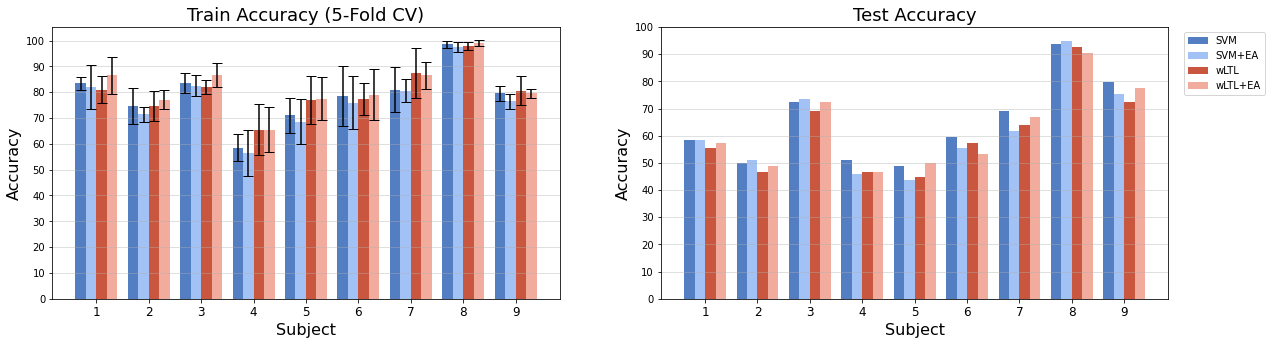

In [105]:
xpos = np.arange(0, 18, step=2)
w = 0.4
colorlist = {
    'svm' : '#537ec2',
    'svm+EA' : '#a2c2f5',
    'wLTL' : '#c95740',
    'wLTL+EA' : '#f2ac9d'
}


fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 5))
ax0.set_title('Train Accuracy (5-Fold CV)',fontsize=18)
ax0.bar(xpos, score_tr_svm, yerr=std_svm, capsize=5, width=w, label='SVM', color=colorlist['svm'])
ax0.bar(xpos+w, score_tr_svm_EA, yerr=std_wLTL, capsize=5, width=w, label='SVM+EA', color=colorlist['svm+EA'])
ax0.bar(xpos+(w*2), score_tr_wLTL, yerr=std_svm_EA, capsize=5, width=w, label='wLTL', color=colorlist['wLTL'])
ax0.bar(xpos+(w*3), score_tr_wLTL_EA, yerr=std_wLTL_EA, capsize=5, width=w, label='wLTL+EA', color=colorlist['wLTL+EA'])
ax0.set_xticks(xpos+w+0.2)
ax0.set_yticks(np.arange(0, 101, 10))
ax0.set_xticklabels(np.arange(1, 10), fontsize=12)
ax0.set_xlabel('Subject', fontsize=16)
ax0.set_ylabel('Accuracy', fontsize=16)
ax0.grid(axis='y', alpha=0.5)

ax1.set_title('Test Accuracy', fontsize=18)
ax1.bar(xpos, score_te_svm, width=w, label='SVM', color=colorlist['svm'])
ax1.bar(xpos+w, score_te_svm_EA, width=w, label='SVM+EA', color=colorlist['svm+EA'])
ax1.bar(xpos+(w*2), score_te_wLTL, width=w, label='wLTL', color=colorlist['wLTL'])
ax1.bar(xpos+(w*3), score_te_wLTL_EA, width=w, label='wLTL+EA', color=colorlist['wLTL+EA'])
ax1.set_xticks(xpos+w+0.2)
ax1.set_yticks(np.arange(0, 101, 10))
# ax.set_yticks(np.arange(1, 10))
ax1.set_xticklabels(np.arange(1, 10), fontsize=12)
ax1.set_xlabel('Subject', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=16)

ax1.grid(axis='y', alpha=0.5)
ax1.legend(loc=1, bbox_to_anchor=(1.2, 1))
plt.savefig('result.png')
plt.show()

# Try comparing SVM, SVM_EA, LDA, LDA_EA
Randomized 10 trials 30 times from each subject, then average result.  
For EA approach, also add the features from source subject to build model   
There are four patterns that will be compared for each model
1. **Pattern 1**: train on target training 10 trials_no_EA, test on target test_no_EA
2. **Pattern 2**: train on target training 10 trials EA, test on target test EA (this will not contribute much)  
3. **Pattern 3**: target training trials first is EA-ed with all source trials, should be 10 + (8 * 144) trials (1162 trials)  
    training using these trials  
    then test trials is EA-ed with training trials of target subject
4. **Pattern 4**: target training trials + source trials without EA  
    training using these trials  
    then test trials to evaluate model (should worsen the model)

In [58]:
# library to store all score
scores = {}
scores['svm'] = {}
scores['lda'] = {}


# Library to store target and source data
TL_data2 = {}
TL_data2['tgt'] = {}
TL_data2['src'] = {}

In [59]:
mod_data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [56]:
# First transfer all trials EA and non EA into TL_data2
for subj in mod_data.keys():
    print('Copying data of subject', subj)
    TL_data2['tgt'][subj] = {}
    TL_data2['src'][subj] = {}
    
    # Target
    TL_data2['tgt'][subj]['all_trials'] = deepcopy(mod_data[subj]['all_trials'])
    TL_data2['tgt'][subj]['all_trials_EA'] = deepcopy(mod_data[subj]['all_trials_EA'])
    TL_data2['tgt'][subj]['y'] = deepcopy(mod_data[subj]['y'])    

    # Subject
    TL_data2['src'][subj]['all_trials'] = deepcopy(mod_data[subj]['all_trials'])
    TL_data2['src'][subj]['all_trials_EA'] = deepcopy(mod_data[subj]['all_trials_EA'])    
    TL_data2['src'][subj]['y'] = deepcopy(mod_data[subj]['y'])    


Copying data of subject 1
Copying data of subject 2
Copying data of subject 3
Copying data of subject 4
Copying data of subject 5
Copying data of subject 6
Copying data of subject 7
Copying data of subject 8
Copying data of subject 9


In [57]:
import numpy.linalg as la

def csp_feat_ver5(XtrainRaw, XtestRaw, ytr, n_filter=3):
    '''
    Another adaptatino of MATAB csp feat function, this time function will receive EEG trials raw data
    
    Parameter:
    XtrainRaw : train trials, shape of trials x channels x samples
    XtestRaw : test trials, shape of trials x channels x samples
    ytr : the label class of training data, 1D shape of (trials, )
    n_filter: number of filter for spatial filter
    
    Return:
    feat_train: csp feature training, shape of samples x 2*n_filters
    feat_test: csp feature training, shape of samples x 2*n_filters

    '''
    
    ids_left = np.argwhere(ytr == 0).ravel()
    ids_right = np.argwhere(ytr == 1).ravel()

    EEG_left = XtrainRaw[ids_left]
    EEG_right = XtrainRaw[ids_right]

    # Covariance of left and right
    cov_left = 0
    for signal in EEG_left:
        cov_left += np.cov(signal, rowvar=True, ddof=1)

    cov_left = cov_left/EEG_left.shape[0]

    cov_right = 0
    for signal in EEG_right:
        cov_right += np.cov(signal, rowvar=True, ddof=1)

    cov_right = cov_right/EEG_right.shape[0]

    mldiv = la.lstsq(cov_right, cov_left, rcond=None)[0]

    # Eigenvector and eigenvalues
    [eigval, eigvec] = la.eig(mldiv)

    # Sort, descending order, eigvec
    ids_dsc = np.argsort(eigval)[::-1]
    eigvec = eigvec[:, ids_dsc]

    # W matrix
    W = np.delete(eigvec, np.s_[n_filter:-n_filter], axis=1)

    # Calculating feature train 
    feat_train = []
    for trial in XtrainRaw:
        X = W.T@trial
        feat_train.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 
    
    # Calculating feature test 
    feat_test = []
    for trial in XtestRaw:
        X = W.T@trial
        feat_test.append(np.log10(np.diag(X@X.T)/np.trace(X@X.T)) ) 
    
    return np.array(feat_train), np.array(feat_test)

## Pattern 1  
Train samples: 10 samples non-EA raw data (target subject)   
Test samples: 134 samples (target subject)

In [28]:
# def svm_lda_pattern1():
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import random

def svm_lda(data, n_iter=30, pattern=1):
    '''
    The steps in this function:
    1. iterate over all target subject
    2. take 10 trials of target subject, this serves as training data (XtrRaw)
    3. the rest of data will be test data (XteRaw)
    4. also get the ytr (ytr)
    5. get the feature csp using csp_feat_ver5()
    6. build svm model, trained on feat_train
    7. evaluate model on feat_test
    8. repeat 30 times, the result is average of all iteration
    '''
    
    # This will store all mean and std score
    score_svm = []
    std_svm = []
    score_lda = []
    std_lda = []
    
    # Decide which pattern to evaluate
    if pattern == 1:    
        print('Pattern 1')
        # Define the Xraw and y data
        Xraw = data['all_trials']
        y = data['y']
    else:
        print('Pattern 2')
        Xraw = data['all_trials_EA']
        y = data['y']
            
    # Iterate n_iter times
    for i in range(n_iter):
        print('Iteration ', i, end=" ")

        # Randomly generate 10 integer to get index for training data:
        ids_train = random.sample(range(len(Xraw)), 10)

        # Define ids_train, make sure that ids_train has equal samples from both classes
        while (y[ids_train] == 1).sum() != 5:
            # print('Finding another index ...')
            ids_train = random.sample(range(len(Xraw)), 10)
        
        # print('Index found')
        # Define index test 
        ids_test = np.arange(0, len(Xraw))
        ids_test = np.delete(ids_test, ids_train)
        
        # Define XtrRaw, XteRaw, ytr, and yte
        XtrRaw = Xraw[ids_train]
        XteRaw = Xraw[ids_test]
        ytr = y[ids_train]
        yte = y[ids_test]
    
        assert len(XtrRaw) == 10
        assert len(XteRaw) == 134
        
        # Pass them into csp function to compute feat_train and feat_test
        feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr, n_filter=3)
    
        # Define model, fit, and evaluate of test data
        model_svm = SVC()
        model_lda = LDA()

        _ = model_svm.fit(feat_train, ytr)
        _ = model_lda.fit(feat_train, ytr)

        score_svm.append(model_svm.score(feat_test, yte))
        score_lda.append(model_lda.score(feat_test, yte))
    
    print('Computing average of {} score'.format(i+1))
    # Append each mean and std result
    mean_svm = np.mean(score_svm)
    std_svm = np.std(score_svm)

    mean_lda = np.mean(score_lda)
    std_lda = np.std(score_lda)

    return mean_svm, std_svm, mean_lda, std_lda

In [29]:
# Iterate over all target subject
for t_subj in TL_data2['tgt'].keys():
    print('== Processing subject %d ==' %t_subj)
    TL_data2['tgt'][t_subj]['pattern_1'] = {}
    target_subj = TL_data2['tgt'][t_subj]['pattern_1']
    
    target_subj['mean_svm'], target_subj['std_svm'], target_subj['mean_lda'], target_subj['std_lda'] = svm_lda(TL_data2['tgt'][t_subj], n_iter=30, pattern=1)
    print('')

== Processing subject 1 ==
Pattern 1
Iteration  0 Iteration  1 Iteration  2 Iteration  3 Iteration  4 Iteration  5 Iteration  6 Iteration  7 Iteration  8 Iteration  9 Iteration  10 Iteration  11 Iteration  12 Iteration  13 Iteration  14 Iteration  15 Iteration  16 Iteration  17 Iteration  18 Iteration  19 Iteration  20 Iteration  21 Iteration  22 Iteration  23 Iteration  24 Iteration  25 Iteration  26 Iteration  27 Iteration  28 Iteration  29 Computing average of 30 score

== Processing subject 2 ==
Pattern 1
Iteration  0 Iteration  1 Iteration  2 Iteration  3 Iteration  4 Iteration  5 Iteration  6 Iteration  7 Iteration  8 Iteration  9 Iteration  10 Iteration  11 Iteration  12 Iteration  13 Iteration  14 Iteration  15 Iteration  16 Iteration  17 Iteration  18 Iteration  19 Iteration  20 Iteration  21 Iteration  22 Iteration  23 Iteration  24 Iteration  25 Iteration  26 Iteration  27 Iteration  28 Iteration  29 Computing average of 30 score

== Processing subject 3 ==
Pattern 1
Iterati

In [30]:
# Sanity check
assert 'mean_svm' and 'mean_lda' and 'std_svm' and 'std_lda' in TL_data2['tgt'][1]['pattern_1'].keys()

## Pattern 2
Train samples: 10 samples EA raw data (target subject)   
Test samples: 134 samples (target subject)  
*basically same as pattern 1 only this time use EA-ed trials*

In [31]:
# Iterate over all target subject
for t_subj in TL_data2['tgt'].keys():
    print('== Processing subject %d ==' %t_subj)
    TL_data2['tgt'][t_subj]['pattern_2'] = {}
    target_subj = TL_data2['tgt'][t_subj]['pattern_2']
    
    target_subj['mean_svm'], target_subj['std_svm'], target_subj['mean_lda'], target_subj['std_lda'] = svm_lda(TL_data2['tgt'][t_subj], n_iter=30, pattern=2)
    print('')

== Processing subject 1 ==
Pattern 2
Iteration  0 Iteration  1 Iteration  2 Iteration  3 Iteration  4 Iteration  5 Iteration  6 Iteration  7 Iteration  8 Iteration  9 Iteration  10 Iteration  11 Iteration  12 Iteration  13 Iteration  14 Iteration  15 Iteration  16 Iteration  17 Iteration  18 Iteration  19 Iteration  20 Iteration  21 Iteration  22 Iteration  23 Iteration  24 Iteration  25 Iteration  26 Iteration  27 Iteration  28 Iteration  29 Computing average of 30 score

== Processing subject 2 ==
Pattern 2
Iteration  0 Iteration  1 Iteration  2 Iteration  3 Iteration  4 Iteration  5 Iteration  6 Iteration  7 Iteration  8 Iteration  9 Iteration  10 Iteration  11 Iteration  12 Iteration  13 Iteration  14 Iteration  15 Iteration  16 Iteration  17 Iteration  18 Iteration  19 Iteration  20 Iteration  21 Iteration  22 Iteration  23 Iteration  24 Iteration  25 Iteration  26 Iteration  27 Iteration  28 Iteration  29 Computing average of 30 score

== Processing subject 3 ==
Pattern 2
Iterati

In [32]:
# Sanity check
assert 'mean_svm' and 'mean_lda' and 'std_svm' and 'std_lda' in TL_data2['tgt'][1]['pattern_2'].keys()

## Pattern 3
- train samples: 10 target traininng EA trials + all sources data EA trials (10 + 8 x 144 ) trials
- test samples: 134 target test EA trials

In [33]:
TL_data2['tgt'][1].keys()

dict_keys(['all_trials', 'all_trials_EA', 'y', 'pattern_1', 'pattern_2'])

In [34]:
from copy import deepcopy
import random

def svm_lda_pattern34(data, tgt_subj=1, n_iter=30, pattern=3):
    
    # This will store all mean and std score
    score_svm = []
    std_svm = []
    score_lda = []
    std_lda = []

    # Subjects that act as current source subject
    sources = [i for i in data['src'].keys() if i != tgt_subj]

    # Stacking all source subject X and y trials_EA
    src_trials_EA = np.array([])
    src_y = np.array([])
    
    print('Getting source trials from subject ', sources)
    
    for src_subj in sources:
        current_trial_EA = deepcopy(data['src'][src_subj]['all_trials_EA'])
        current_y = deepcopy(data['src'][src_subj]['y'])

        if len(src_trials_EA) == 0:
            src_trials_EA = current_trial_EA
            src_y = current_y
        else :
            src_trials_EA = np.concatenate([src_trials_EA, current_trial_EA], axis=0)
            src_y = np.concatenate([src_y, current_y])
    
    if pattern == 3:
        print('Pattern 3')
        # Get data from the target 
        Xraw = data['tgt'][tgt_subj]['all_trials_EA']
    else:
        print('Pattern 4')
        # Get data from the target 
        Xraw = data['tgt'][tgt_subj]['all_trials']
    
    y = data['tgt'][tgt_subj]['y']
    
    # Iterate n_iter times
    print('Iteration', end = ' ')
    for i in range(n_iter):
        print(i, end = " ")

        # Randomly generate 10 integer to get index for training data:
        ids_train = random.sample(range(len(Xraw)), 10)

        # Define ids_train, make sure that ids_train has equal samples from both classes
        while (y[ids_train] == 1).sum() != 5:
            ids_train = random.sample(range(len(Xraw)), 10)
        
        # print(ids_train.shape)
        # print(ids_test.shape)
        
        # Define index test 
        ids_test = np.arange(0, len(Xraw))
        ids_test = np.delete(ids_test, ids_train, axis=0)
        
        assert len(ids_test) == 134
        assert len(ids_train) == 10
        #print(Xraw.shape)
        #print('this should be always ten:', ids_train.shape)
        #print('this strange:', ids_test.shape)
        
        # Define XtrRaw, XteRaw, ytr, and yte
        XtrRaw = Xraw[ids_train]
        XteRaw = Xraw[ids_test]
        ytr = y[ids_train]
        yte = y[ids_test]
        
        #print('XteRaw shape:', XteRaw.shape)
        #print('XtrRaw shape:', XtrRaw.shape)
        # Stack XtrRaw and y of target with all source trials
        XteRaw = np.concatenate([src_trials_EA, XteRaw], axis=0)
        # ytr = np.concatenate([src_y, ytr], axis=0)

        assert len(XteRaw) == 1286

        # Pass them into csp function to compute feat_train and feat_test
        feat_train, feat_test = csp_feat_ver5(XtrRaw, XteRaw, ytr, n_filter=3)

        # feat and y of target training trials + source trials
        feat_train = np.concatenate([feat_train, feat_test[:len(src_trials_EA)]], axis=0)
        ytr = np.concatenate([src_y, ytr], axis=0)

        feat_test = feat_test[len(src_trials_EA):]

        assert len(feat_train) == 1162
        assert len(ytr) == 1162
        assert len(feat_test) == 134

        # Define model, fit, and evaluate of test data
        model_svm = SVC()
        model_lda = LDA()

        _ = model_svm.fit(feat_train, ytr)
        _ = model_lda.fit(feat_train, ytr)

        # Storing current score into list
        score_svm.append(model_svm.score(feat_test, yte))
        score_lda.append(model_lda.score(feat_test, yte))

    print('Computing average of {} score'.format(i+1))
    # Append each mean and std result
    mean_svm = np.mean(score_svm)
    std_svm = np.std(score_svm)

    mean_lda = np.mean(score_lda)
    std_lda = np.std(score_lda)

    return mean_svm, std_svm, mean_lda, std_lda

In [35]:
# Iterate over all subject as target
for tgt_subj in TL_data2['tgt'].keys():
    print('Processing subject', tgt_subj)
    
    # Define new keys inside each target subject
    TL_data2['tgt'][tgt_subj]['pattern_3'] = {}
    
    target_subj = TL_data2['tgt'][tgt_subj]['pattern_3']
    target_subj['mean_svm'], target_subj['std_svm'], target_subj['mean_lda'], target_subj['std_lda'] = svm_lda_pattern34(TL_data2, tgt_subj= tgt_subj, n_iter=30, pattern=3)
    print(' ')

Processing subject 1
Getting source trials from subject  [2, 3, 4, 5, 6, 7, 8, 9]
Pattern 3
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 2
Getting source trials from subject  [1, 3, 4, 5, 6, 7, 8, 9]
Pattern 3
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 3
Getting source trials from subject  [1, 2, 4, 5, 6, 7, 8, 9]
Pattern 3
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 4
Getting source trials from subject  [1, 2, 3, 5, 6, 7, 8, 9]
Pattern 3
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 5
Getting source trials from subject  [1, 2, 3, 4, 6, 7, 8, 9]
Pattern 3
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 1

In [36]:
# Sanity check
assert 'mean_svm' and 'mean_lda' and 'std_svm' and 'std_lda' in TL_data2['tgt'][1]['pattern_3'].keys()

## Pattern 4

In [38]:
# Iterate over all subject as target
for tgt_subj in TL_data2['tgt'].keys():
    print('Processing subject', tgt_subj)
    
    # Define new keys inside each target subject
    TL_data2['tgt'][tgt_subj]['pattern_4'] = {}
    
    target_subj = TL_data2['tgt'][tgt_subj]['pattern_4']
    target_subj['mean_svm'], target_subj['std_svm'], target_subj['mean_lda'], target_subj['std_lda'] = svm_lda_pattern34(TL_data2, tgt_subj= tgt_subj, n_iter=30, pattern = 4)
    print(' ')

Processing subject 1
Getting source trials from subject  [2, 3, 4, 5, 6, 7, 8, 9]
Pattern 4
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 2
Getting source trials from subject  [1, 3, 4, 5, 6, 7, 8, 9]
Pattern 4
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 3
Getting source trials from subject  [1, 2, 4, 5, 6, 7, 8, 9]
Pattern 4
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 4
Getting source trials from subject  [1, 2, 3, 5, 6, 7, 8, 9]
Pattern 4
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 Computing average of 30 score
 
Processing subject 5
Getting source trials from subject  [1, 2, 3, 4, 6, 7, 8, 9]
Pattern 4
Iteration 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 1

In [39]:
# Sanity check
assert 'mean_svm' and 'mean_lda' and 'std_svm' and 'std_lda' in TL_data2['tgt'][1]['pattern_4'].keys()

In [45]:
TL_data2['tgt'][1]['pattern_3']['mean_svm']

0.48756218905472637

#### Result

In [46]:
pattern = ['pattern_1', 'pattern_2', 'pattern_3', 'pattern_4']

for pat in pattern:
    print(' ===== {} ==== '.format(pat))
    print('\t\t\t Score SVM\t\t\t Score LDA')
    
    for t_subj in TL_data2['tgt'].keys():
        score_svm = TL_data2['tgt'][t_subj][pat]['mean_svm']
        std_svm = TL_data2['tgt'][t_subj][pat]['std_svm']
        score_lda = TL_data2['tgt'][t_subj][pat]['mean_lda']
        std_lda = TL_data2['tgt'][t_subj][pat]['std_lda']

        print('Subject{:02d} :\t\t {:.3f} +/- {:.3f} \t\t {:.3f} +/- {:.3f}'.format(t_subj, score_svm, std_svm, score_lda, std_lda))

 ===== pattern_1 ==== 
			 Score SVM			 Score LDA
Subject01 :		 0.550 +/- 0.039 		 0.532 +/- 0.042
Subject02 :		 0.506 +/- 0.038 		 0.529 +/- 0.039
Subject03 :		 0.641 +/- 0.066 		 0.616 +/- 0.098
Subject04 :		 0.503 +/- 0.039 		 0.510 +/- 0.041
Subject05 :		 0.503 +/- 0.044 		 0.504 +/- 0.042
Subject06 :		 0.523 +/- 0.036 		 0.517 +/- 0.033
Subject07 :		 0.531 +/- 0.037 		 0.526 +/- 0.040
Subject08 :		 0.855 +/- 0.045 		 0.780 +/- 0.087
Subject09 :		 0.739 +/- 0.029 		 0.654 +/- 0.082
 ===== pattern_2 ==== 
			 Score SVM			 Score LDA
Subject01 :		 0.542 +/- 0.054 		 0.536 +/- 0.048
Subject02 :		 0.494 +/- 0.035 		 0.486 +/- 0.042
Subject03 :		 0.674 +/- 0.056 		 0.644 +/- 0.089
Subject04 :		 0.501 +/- 0.037 		 0.507 +/- 0.042
Subject05 :		 0.506 +/- 0.043 		 0.509 +/- 0.041
Subject06 :		 0.508 +/- 0.038 		 0.506 +/- 0.043
Subject07 :		 0.520 +/- 0.047 		 0.512 +/- 0.040
Subject08 :		 0.852 +/- 0.052 		 0.792 +/- 0.100
Subject09 :		 0.711 +/- 0.042 		 0.626 +/- 0.079
 ===== pattern_3 =